# **Credit Card Customer Segmentation: A Comparative Study of Clustering Algorithms**

# Table of Contents

## 0. Setup and Data Collection
- 0.1 Data Provenance
- Package Installation
- Library Imports
- Data Loading

## 1. Problem Definition
- 1.1 Problem Statement
- 1.2 Data Description
- Basic Information
- Statistical Summary

## 2. Exploratory Data Analysis
- 2.1 Missing Values Analysis
- 2.2 Feature Distributions
- 2.3 Correlation Analysis
- 2.4 Outlier Detection
- 2.5 Feature Relationships

## 3. Data Preprocessing
- 3.1 Handling Missing Values
- 3.2 Feature Engineering
- 3.3 Feature Scaling
- 3.4 Dimensionality Reduction (PCA)

## 4. Model Development
- 4.1 Determining Optimal Number of Clusters
- 4.2 K-Means Clustering
- 4.3 Hierarchical Clustering
- 4.4 DBSCAN Clustering

## 5. Results and Evaluation
- 5.1 Clustering Metrics Comparison
- 5.2 Cluster Visualization
- 5.3 Cluster Profiling
- 5.4 Customer Segment Analysis

## 6. Discussion and Conclusions
- 6.1 Discussion of Data Exploration (EDA)
- 6.2 Model Performance Analysis
- 6.3 Business Implications
- 6.4 Limitations
- 6.5 Future Work
- 6.6 Conclusions

## 7. References

## 8. GitHub Repository

# 0. Setup and Data Collection

## 0.1 Data Provenance

- **Dataset Name:** Credit Card Dataset for Clustering  

- **Source:** Kaggle (CC GENERAL Dataset)  

- **Sample Size:** 8,950 customers  

- **Features:** 17 behavioral features related to credit card usage

- **Task:** Customer segmentation using unsupervised learning

- **Time Period:** Usage behavior summarized over 6 months

In [1]:
!pip install scikit-learn pandas numpy matplotlib seaborn yellowbrick -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

np.random.seed(20250523)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [3]:
from google.colab import files
import io

uploaded = files.upload()

# Get the first uploaded file
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

df.head()

Saving CC GENERAL.csv to CC GENERAL.csv


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# 1. Problem Definition

## 1.1 Problem Statement

- **Problem Type:** Unsupervised Learning (Clustering)

- **Objective:** Segment credit card customers into distinct groups based on their usage behavior to help marketing teams develop targeted strategies.

- **Business Goal:** Identify customer segments for personalized marketing campaigns, risk assessment, and customer retention strategies.

- **Approach:** Compare three clustering algorithms:
  - **K-Means:** Partition based clustering with centroid optimization
  - **Hierarchical Clustering:** Agglomerative approach building cluster hierarchy
  - **DBSCAN:** Density based clustering for identifying arbitrary shaped clusters

## 1.2 Data Description

| Feature | Description | Unit |
|---------|-------------|------|
| CUST_ID | Unique identifier for each customer | ID |
| BALANCE | Balance amount left in account to make purchases | USD |
| BALANCE_FREQUENCY | How frequently the balance is updated | ratio (0 to 1) |
| PURCHASES | Total amount of purchases made from account | USD |
| ONEOFF_PURCHASES | Maximum single purchase amount | USD |
| INSTALLMENTS_PURCHASES | Amount of purchases done in installments | USD |
| CASH_ADVANCE | Cash in advance given by the user | USD |
| PURCHASES_FREQUENCY | How frequently purchases are being made | ratio (0 to 1) |
| ONEOFF_PURCHASES_FREQUENCY | Frequency of one time purchases | ratio (0 to 1) |
| PURCHASES_INSTALLMENTS_FREQUENCY | Frequency of installment purchases | ratio (0 to 1) |
| CASH_ADVANCE_FREQUENCY | Frequency of cash advance transactions | ratio (0 to 1) |
| CASH_ADVANCE_TRX | Number of cash advance transactions | count |
| PURCHASES_TRX | Number of purchase transactions | count |
| CREDIT_LIMIT | Credit limit of the customer | USD |
| PAYMENTS | Amount of payments made by customer | USD |
| MINIMUM_PAYMENTS | Minimum amount of payments made by customer | USD |
| PRC_FULL_PAYMENT | Percentage of full payment paid by customer | ratio (0 to 1) |
| TENURE | Tenure of credit card service in months | months |

In [ ]:
print("Dataset Shape:", df.shape)
print("\n")
df.info()

In [ ]:
df.describe().round(2)

# 2. Exploratory Data Analysis

## 2.1 Missing Values Analysis

In [4]:
# Check for missing values
missing_df = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Percentage': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_df[missing_df['Missing Count'] > 0]

,Missing Count,Percentage
CREDIT_LIMIT,1,0.01
MINIMUM_PAYMENTS,313,3.50


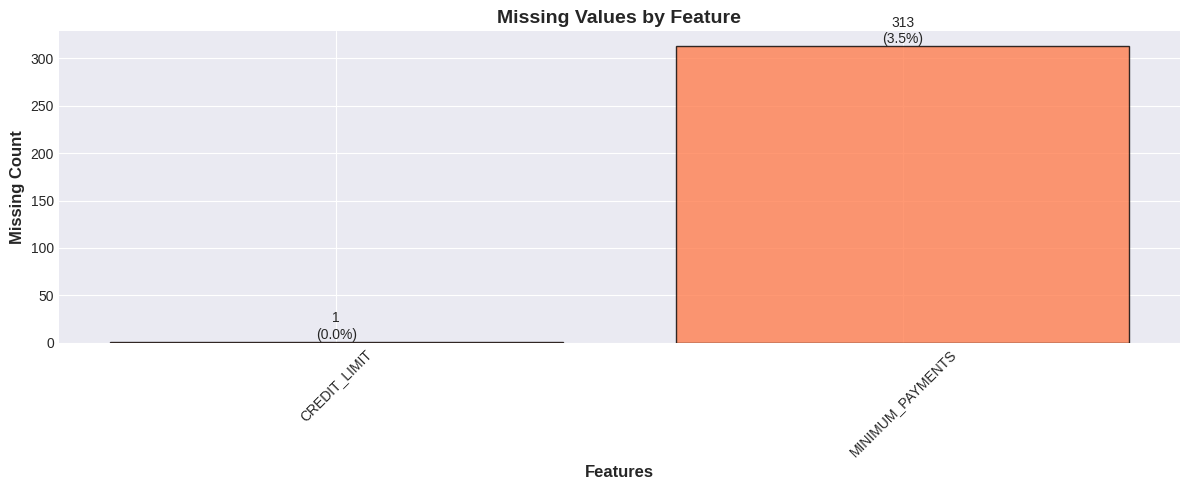

In [5]:
# Visualize missing values
fig, ax = plt.subplots(figsize=(12, 5))

missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]

if len(missing_counts) > 0:
    bars = ax.bar(missing_counts.index, missing_counts.values, color='coral', alpha=0.8, edgecolor='black')
    ax.set_xlabel('Features', fontsize=12, fontweight='bold')
    ax.set_ylabel('Missing Count', fontsize=12, fontweight='bold')
    ax.set_title('Missing Values by Feature', fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}\n({height/len(df)*100:.1f}%)',
                ha='center', va='bottom', fontsize=10)
else:
    ax.text(0.5, 0.5, 'No Missing Values (except shown above)',
            ha='center', va='center', fontsize=14, transform=ax.transAxes)

plt.tight_layout()
plt.show()

## 2.2 Feature Distributions

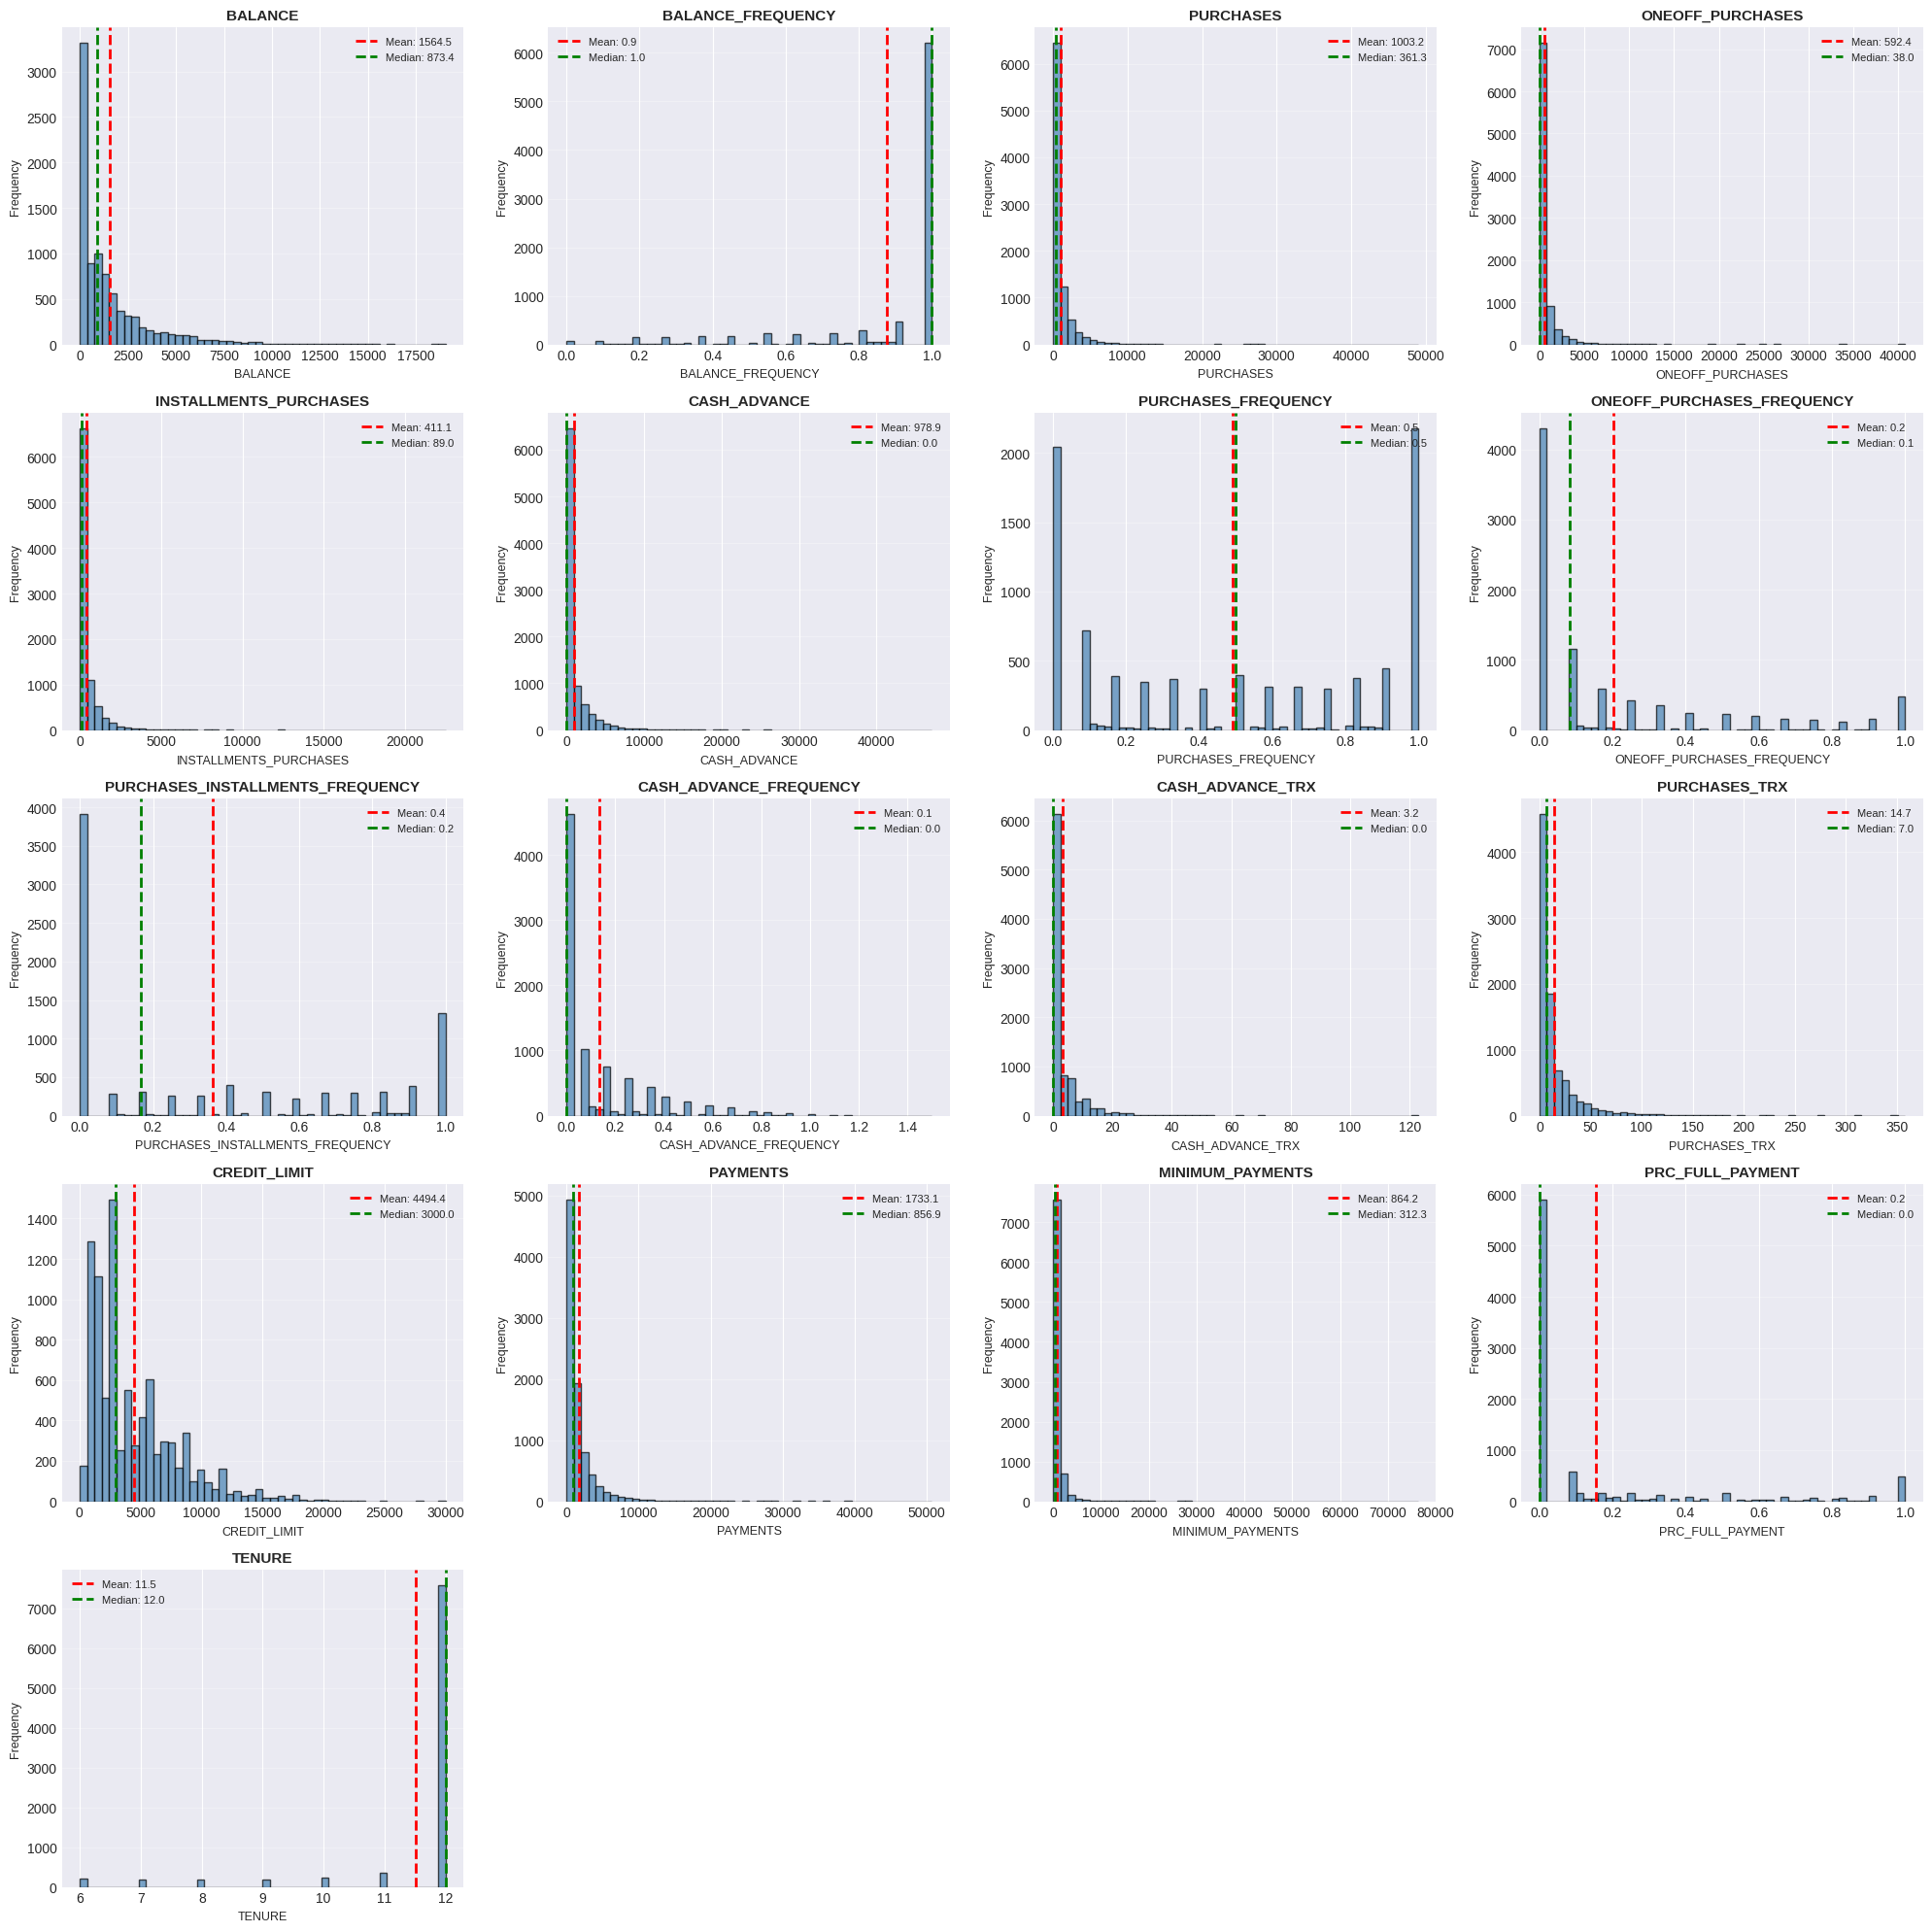

In [6]:
# Select numerical columns (exclude CUST_ID)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

fig, axes = plt.subplots(5, 4, figsize=(20, 20))
axes = axes.ravel()

for idx, col in enumerate(num_cols):
    ax = axes[idx]
    ax.hist(df[col].dropna(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(df[col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[col].mean():.1f}')
    ax.axvline(df[col].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df[col].median():.1f}')
    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.set_xlabel(col, fontsize=9)
    ax.set_ylabel('Frequency', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(axis='y', alpha=0.3)

# Remove empty subplots
for idx in range(len(num_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [7]:
# Check skewness of features
skewness_df = pd.DataFrame({
    'Feature': num_cols,
    'Skewness': [df[col].skew() for col in num_cols],
    'Kurtosis': [df[col].kurtosis() for col in num_cols]
})
skewness_df = skewness_df.sort_values('Skewness', ascending=False)
skewness_df.round(2)

,Feature,Skewness,Kurtosis
14,MINIMUM_PAYMENTS,13.62,283.99
3,ONEOFF_PURCHASES,10.05,164.19
2,PURCHASES,8.14,111.39
4,INSTALLMENTS_PURCHASES,7.30,96.58
13,PAYMENTS,5.91,54.77
10,CASH_ADVANCE_TRX,5.72,61.65
5,CASH_ADVANCE,5.17,52.90
11,PURCHASES_TRX,4.63,34.79
0,BALANCE,2.39,7.67
15,PRC_FULL_PAYMENT,1.94,2.43


## 2.3 Correlation Analysis

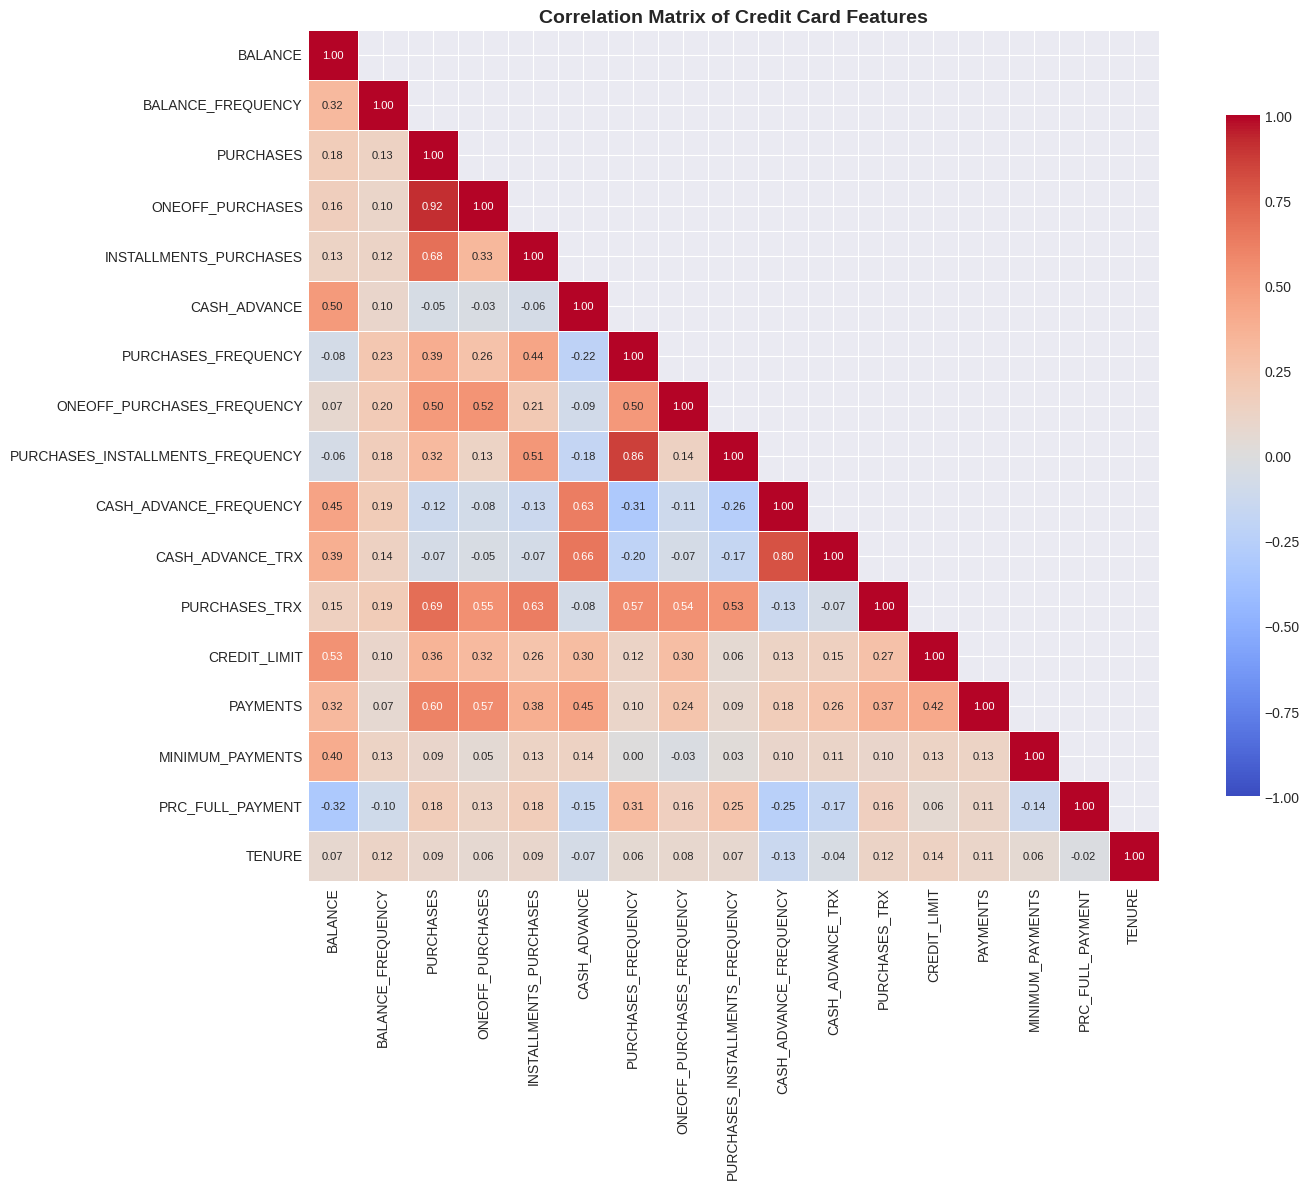

In [8]:
# Compute correlation matrix
corr_matrix = df[num_cols].corr()

fig, ax = plt.subplots(figsize=(16, 12))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            ax=ax, vmin=-1, vmax=1, annot_kws={"size": 8})
ax.set_title('Correlation Matrix of Credit Card Features', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

high_corr_df = pd.DataFrame(high_corr_pairs)
high_corr_df.sort_values('Correlation', ascending=False).round(3)

,Feature 1,Feature 2,Correlation
0,PURCHASES,ONEOFF_PURCHASES,0.917
1,PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,0.863
2,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,0.800


## 2.4 Outlier Detection

In [10]:
# Outlier analysis using IQR method
outlier_summary = []

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_pct = (len(outliers) / len(df)) * 100

    outlier_summary.append({
        'Feature': col,
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Outliers': len(outliers),
        'Percentage': outlier_pct
    })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df = outlier_df.sort_values('Percentage', ascending=False)
outlier_df.round(2)

,Feature,Lower Bound,Upper Bound,Outliers,Percentage
1,BALANCE_FREQUENCY,0.72,1.17,1493,16.68
15,PRC_FULL_PAYMENT,-0.21,0.36,1474,16.47
16,TENURE,12.00,12.00,1366,15.26
5,CASH_ADVANCE,-1670.73,2784.55,1030,11.51
3,ONEOFF_PURCHASES,-866.11,1443.51,1013,11.32
4,INSTALLMENTS_PURCHASES,-702.96,1171.59,867,9.69
14,MINIMUM_PAYMENTS,-815.42,1810.03,841,9.40
13,PAYMENTS,-1893.51,4177.92,808,9.03
2,PURCHASES,-1566.11,2715.87,808,9.03
10,CASH_ADVANCE_TRX,-6.00,10.00,804,8.98


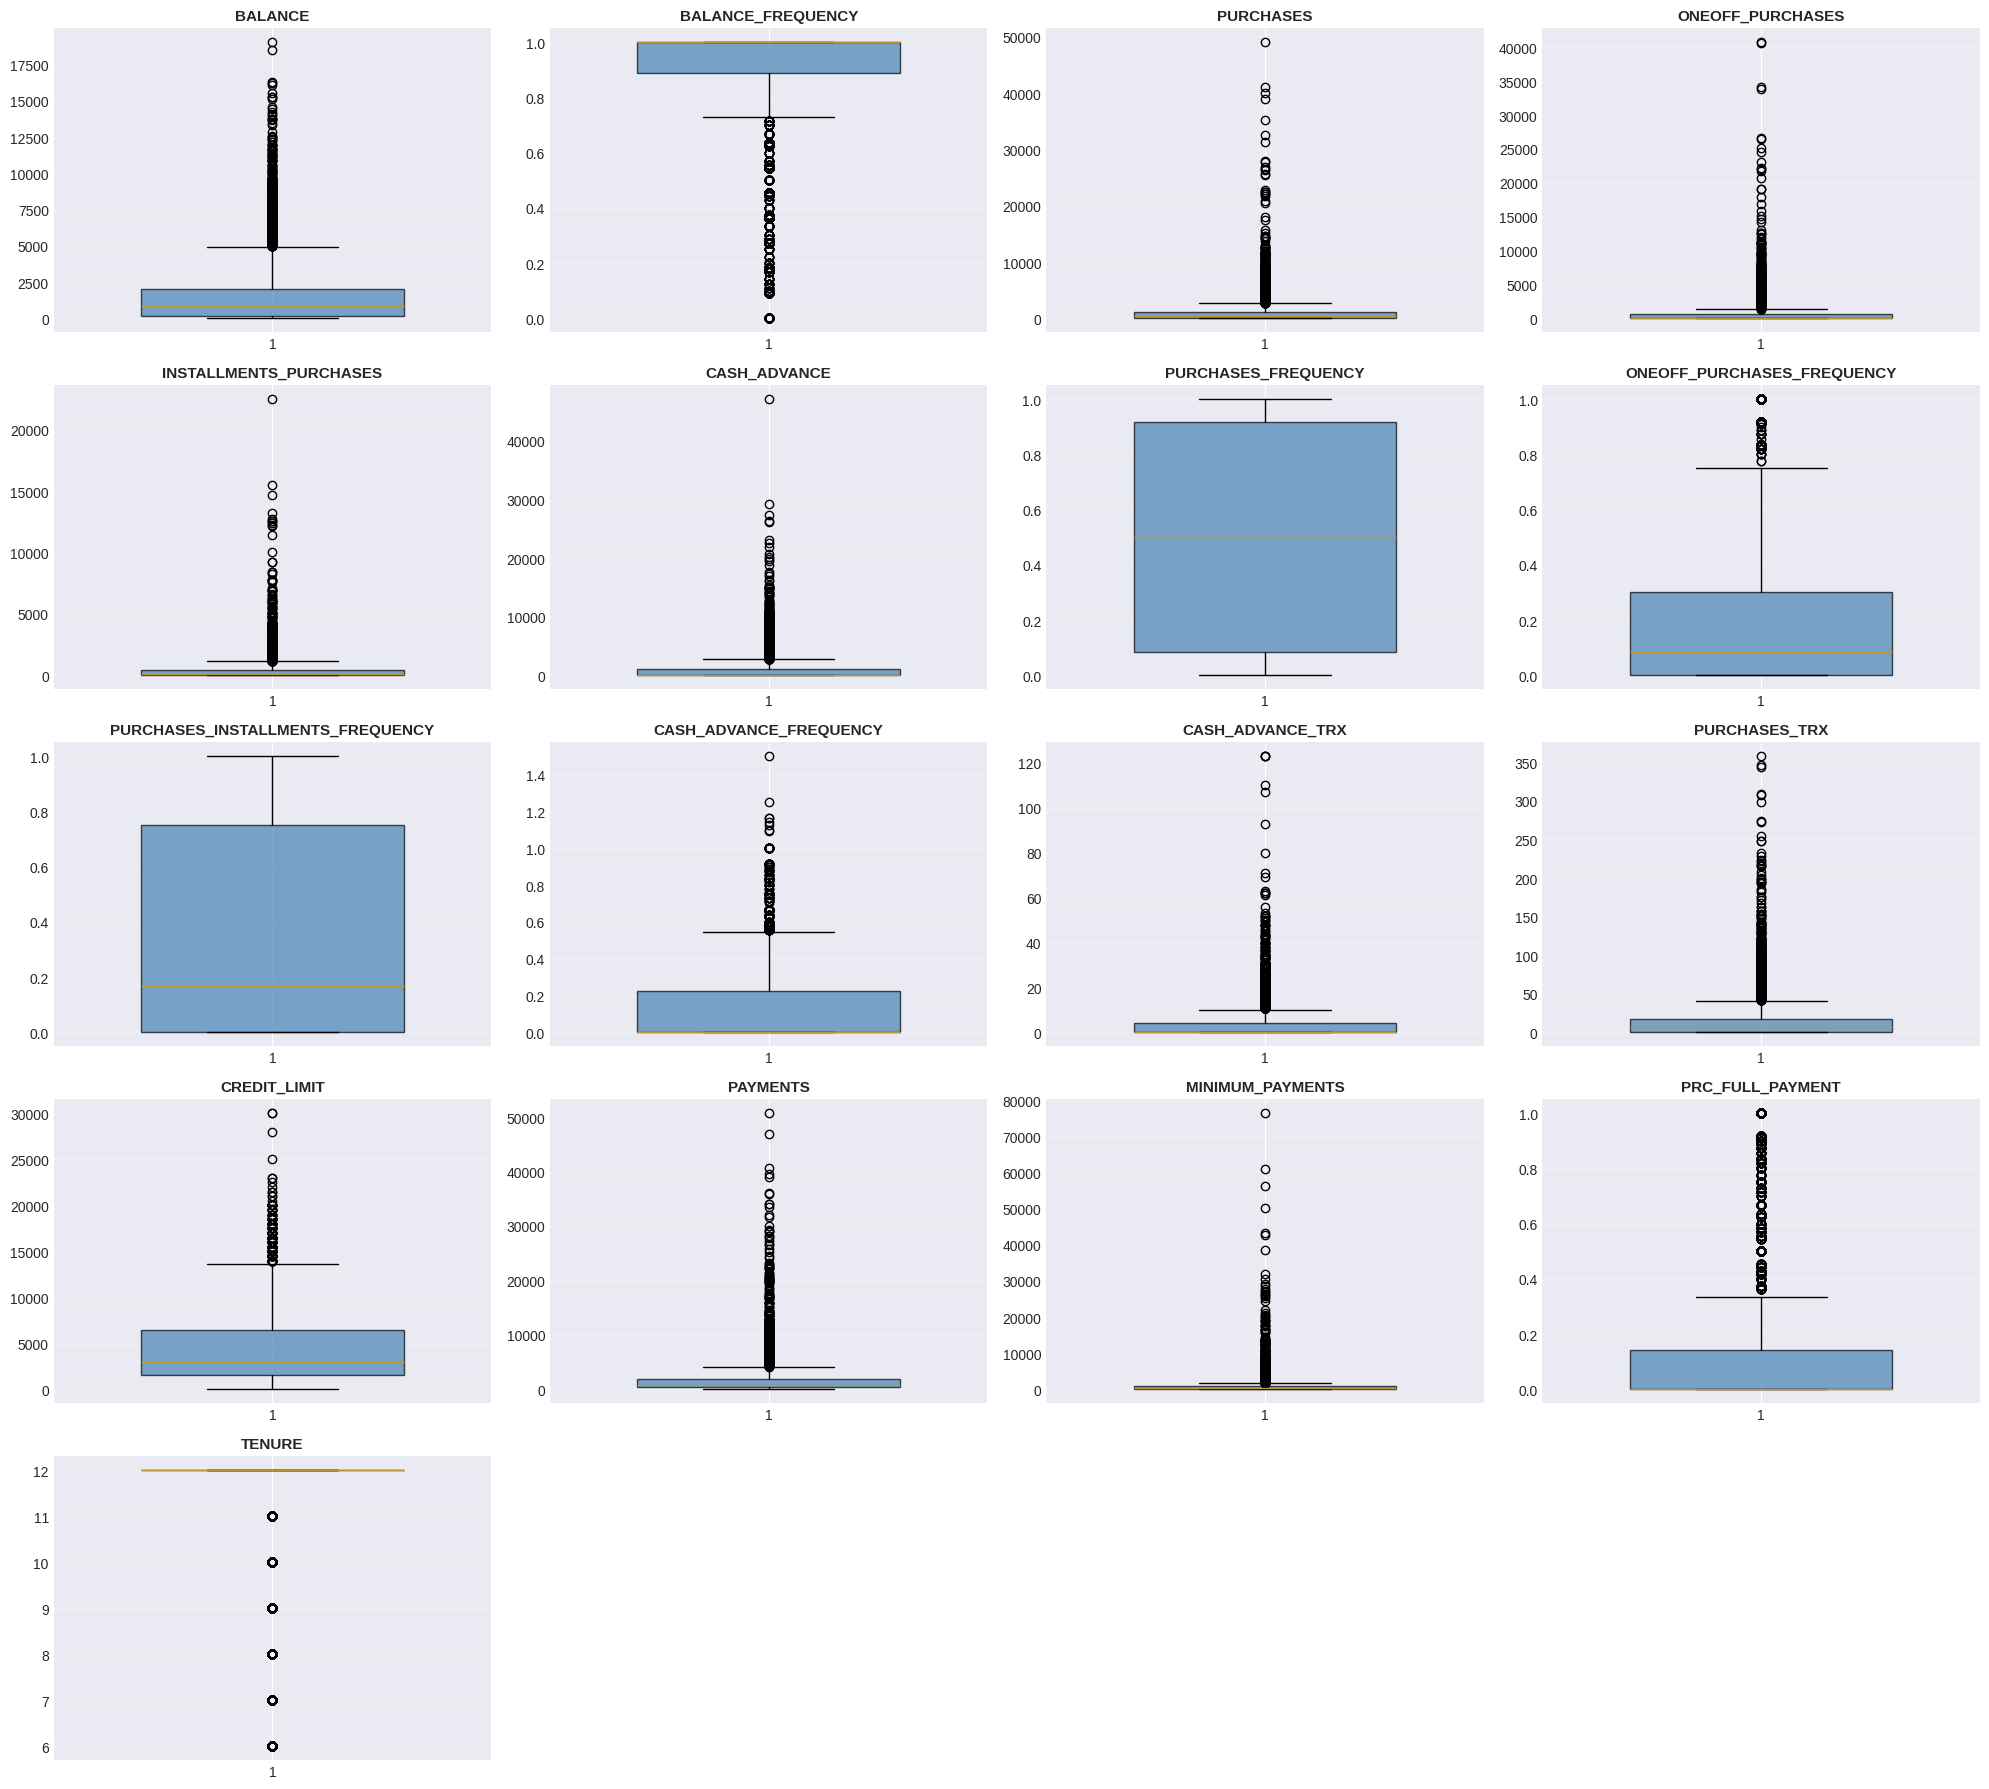

In [11]:
# Visualize outliers with box plots
fig, axes = plt.subplots(5, 4, figsize=(20, 18))
axes = axes.ravel()

for idx, col in enumerate(num_cols):
    ax = axes[idx]
    bp = ax.boxplot(df[col].dropna(), patch_artist=True, widths=0.6)
    bp['boxes'][0].set_facecolor('steelblue')
    bp['boxes'][0].set_alpha(0.7)
    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

for idx in range(len(num_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

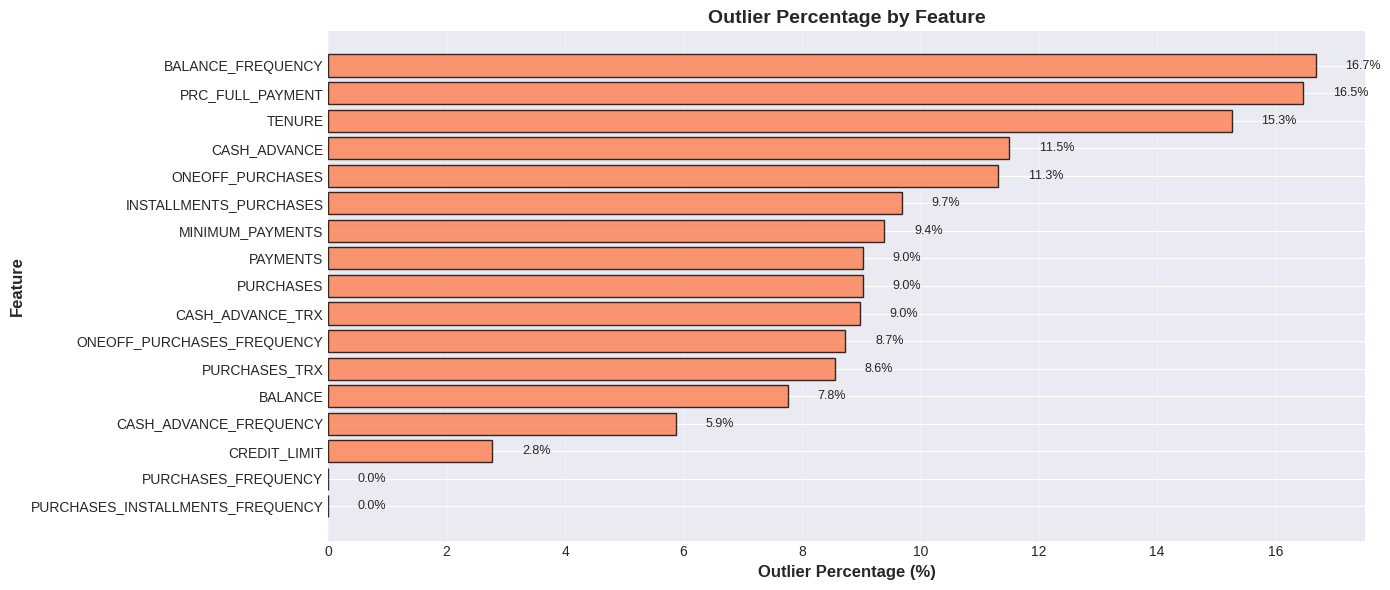

In [12]:
# Bar plot of outlier percentages
fig, ax = plt.subplots(figsize=(14, 6))
outlier_df_sorted = outlier_df.sort_values('Percentage', ascending=True)
bars = ax.barh(outlier_df_sorted['Feature'], outlier_df_sorted['Percentage'],
               color='coral', alpha=0.8, edgecolor='black')
ax.set_xlabel('Outlier Percentage (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Outlier Percentage by Feature', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2.,
            f'{width:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 2.5 Feature Relationships

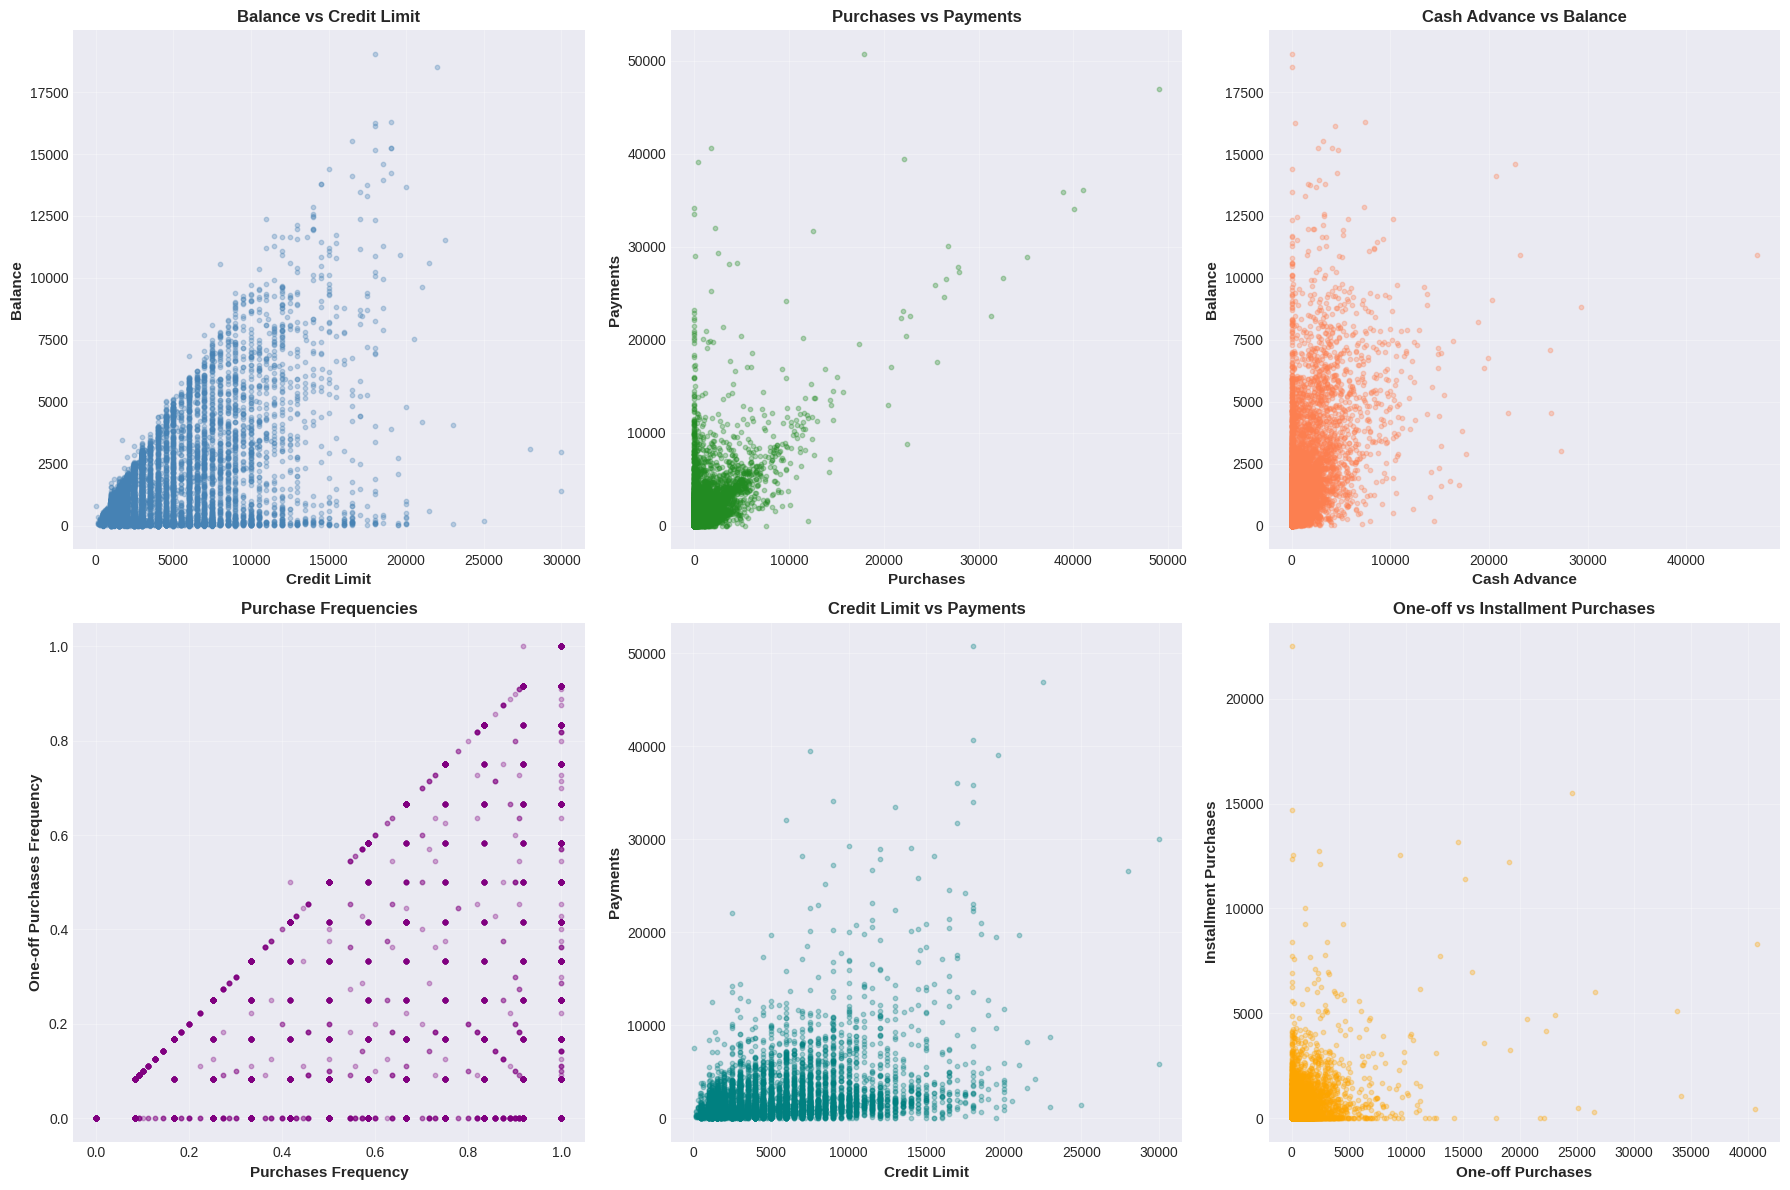

In [13]:
# Key feature relationships
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Balance vs Credit Limit
ax1 = axes[0, 0]
ax1.scatter(df['CREDIT_LIMIT'], df['BALANCE'], alpha=0.3, s=10, color='steelblue')
ax1.set_xlabel('Credit Limit', fontsize=11, fontweight='bold')
ax1.set_ylabel('Balance', fontsize=11, fontweight='bold')
ax1.set_title('Balance vs Credit Limit', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Purchases vs Payments
ax2 = axes[0, 1]
ax2.scatter(df['PURCHASES'], df['PAYMENTS'], alpha=0.3, s=10, color='forestgreen')
ax2.set_xlabel('Purchases', fontsize=11, fontweight='bold')
ax2.set_ylabel('Payments', fontsize=11, fontweight='bold')
ax2.set_title('Purchases vs Payments', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Cash Advance vs Balance
ax3 = axes[0, 2]
ax3.scatter(df['CASH_ADVANCE'], df['BALANCE'], alpha=0.3, s=10, color='coral')
ax3.set_xlabel('Cash Advance', fontsize=11, fontweight='bold')
ax3.set_ylabel('Balance', fontsize=11, fontweight='bold')
ax3.set_title('Cash Advance vs Balance', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Purchases Frequency vs One-off Purchases Frequency
ax4 = axes[1, 0]
ax4.scatter(df['PURCHASES_FREQUENCY'], df['ONEOFF_PURCHASES_FREQUENCY'], alpha=0.3, s=10, color='purple')
ax4.set_xlabel('Purchases Frequency', fontsize=11, fontweight='bold')
ax4.set_ylabel('One-off Purchases Frequency', fontsize=11, fontweight='bold')
ax4.set_title('Purchase Frequencies', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Credit Limit vs Payments
ax5 = axes[1, 1]
ax5.scatter(df['CREDIT_LIMIT'], df['PAYMENTS'], alpha=0.3, s=10, color='teal')
ax5.set_xlabel('Credit Limit', fontsize=11, fontweight='bold')
ax5.set_ylabel('Payments', fontsize=11, fontweight='bold')
ax5.set_title('Credit Limit vs Payments', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

# One-off vs Installment Purchases
ax6 = axes[1, 2]
ax6.scatter(df['ONEOFF_PURCHASES'], df['INSTALLMENTS_PURCHASES'], alpha=0.3, s=10, color='orange')
ax6.set_xlabel('One-off Purchases', fontsize=11, fontweight='bold')
ax6.set_ylabel('Installment Purchases', fontsize=11, fontweight='bold')
ax6.set_title('One-off vs Installment Purchases', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Data Preprocessing

## 3.1 Handling Missing Values

In [14]:
# Create a copy of the dataframe
df_clean = df.copy()

# Drop CUST_ID as it is not useful for clustering
df_clean = df_clean.drop('CUST_ID', axis=1)

# Check missing values before imputation
print("Missing values before imputation:")
print(df_clean.isnull().sum())
print("\n")

# Fill missing values with median (robust to outliers)
for col in df_clean.columns:
    if df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"Filled {col} missing values with median: {median_val:.2f}")

print("\nMissing values after imputation:")
print(df_clean.isnull().sum().sum())

Missing values before imputation:
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64


Filled CREDIT_LIMIT missing values with median: 3000.00
Filled MINIMUM_PAYMENTS missing values with median: 312.34

Missing values after imputation:
0


## 3.2 Feature Engineering

In [15]:
# Create derived features that might help with segmentation
df_features = df_clean.copy()

# Monthly average balance
df_features['MONTHLY_AVG_BALANCE'] = df_features['BALANCE'] / df_features['TENURE']

# Monthly average purchases
df_features['MONTHLY_AVG_PURCHASES'] = df_features['PURCHASES'] / df_features['TENURE']

# Credit utilization ratio
df_features['CREDIT_UTILIZATION'] = df_features['BALANCE'] / (df_features['CREDIT_LIMIT'] + 1)

# Payment to balance ratio
df_features['PAYMENT_RATIO'] = df_features['PAYMENTS'] / (df_features['BALANCE'] + 1)

# Cash advance to credit limit ratio
df_features['CASH_ADVANCE_RATIO'] = df_features['CASH_ADVANCE'] / (df_features['CREDIT_LIMIT'] + 1)

# Purchase type preference (one-off vs installment)
total_purchases = df_features['ONEOFF_PURCHASES'] + df_features['INSTALLMENTS_PURCHASES'] + 1
df_features['ONEOFF_PREFERENCE'] = df_features['ONEOFF_PURCHASES'] / total_purchases

# Handle infinity values
df_features = df_features.replace([np.inf, -np.inf], np.nan)
df_features = df_features.fillna(df_features.median())

print(f"Original features: {len(df_clean.columns)}")
print(f"After feature engineering: {len(df_features.columns)}")
print("\nNew features created:")
print("- MONTHLY_AVG_BALANCE")
print("- MONTHLY_AVG_PURCHASES")
print("- CREDIT_UTILIZATION")
print("- PAYMENT_RATIO")
print("- CASH_ADVANCE_RATIO")
print("- ONEOFF_PREFERENCE")

Original features: 17
After feature engineering: 23

New features created:
- MONTHLY_AVG_BALANCE
- MONTHLY_AVG_PURCHASES
- CREDIT_UTILIZATION
- PAYMENT_RATIO
- CASH_ADVANCE_RATIO
- ONEOFF_PREFERENCE


## 3.3 Feature Scaling

In [16]:
# Standardize features (mean=0, std=1)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)
df_scaled = pd.DataFrame(df_scaled, columns=df_features.columns)

print("Scaled data statistics:")
df_scaled.describe().round(3)

Scaled data statistics:


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,MONTHLY_AVG_BALANCE,MONTHLY_AVG_PURCHASES,CREDIT_UTILIZATION,PAYMENT_RATIO,CASH_ADVANCE_RATIO,ONEOFF_PREFERENCE
count,8950.000,8950.000,8950.000,8950.000,8950.000,8950.000,8950.000,8950.000,8950.000,8950.000,8950.000,8950.000,8950.000,8950.000,8950.000,8950.000,8950.000,8950.000,8950.000,8950.000,8950.000,8950.000,8950.000
mean,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-0.752,-3.703,-0.470,-0.357,-0.455,-0.467,-1.222,-0.679,-0.917,-0.675,-0.476,-0.592,-1.221,-0.599,-0.362,-0.526,-4.123,-0.750,-0.477,-1.001,-0.078,-0.200,-0.891
25%,-0.690,0.049,-0.451,-0.357,-0.455,-0.467,-1.014,-0.679,-0.917,-0.675,-0.476,-0.552,-0.795,-0.466,-0.289,-0.526,0.361,-0.688,-0.459,-0.894,-0.077,-0.200,-0.891
50%,-0.332,0.518,-0.300,-0.334,-0.356,-0.467,0.024,-0.399,-0.498,-0.675,-0.476,-0.310,-0.411,-0.303,-0.228,-0.526,0.361,-0.330,-0.300,-0.222,-0.072,-0.200,-0.631
75%,0.235,0.518,0.050,-0.009,0.064,0.064,1.062,0.327,0.970,0.435,0.110,0.092,0.551,0.058,-0.024,-0.037,0.361,0.234,0.061,0.847,-0.042,0.083,1.168
max,8.397,0.518,22.484,24.201,24.427,22.011,1.270,2.673,1.599,6.821,17.548,13.811,7.010,16.922,32.393,2.893,0.361,9.739,22.163,39.185,69.154,89.216,1.473


## 3.4 Dimensionality Reduction (PCA)

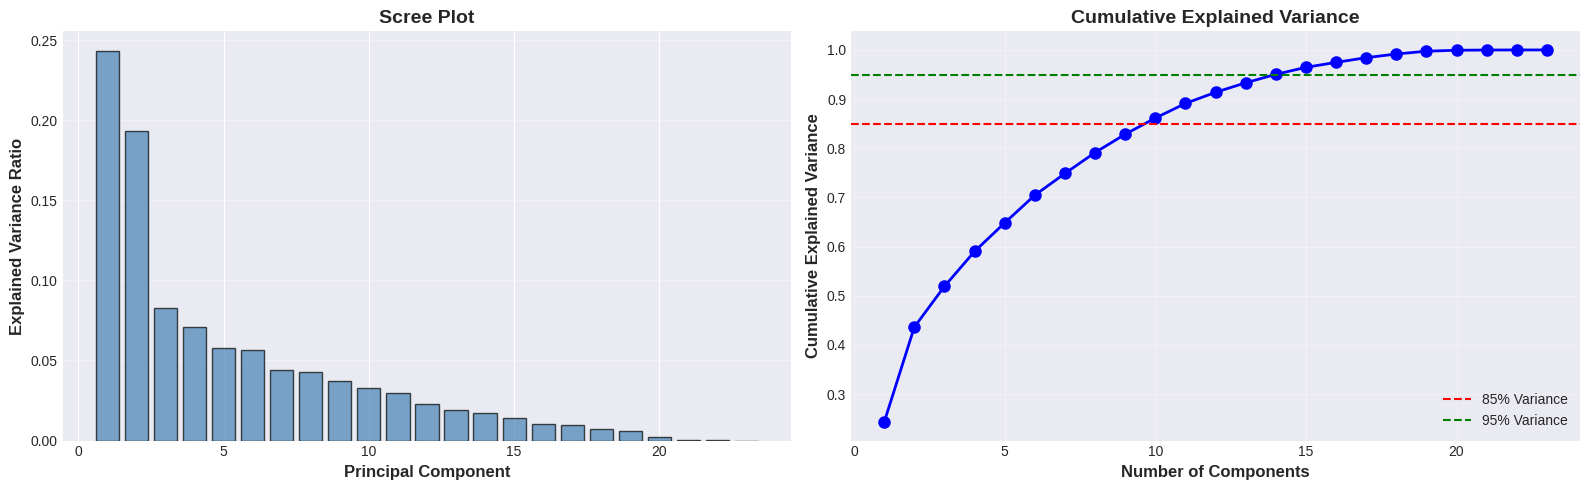

Components needed for 85% variance: 10
Components needed for 95% variance: 14


In [17]:
# Apply PCA to understand variance explained
pca_full = PCA()
pca_full.fit(df_scaled)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Scree plot
ax1 = axes[0]
ax1.bar(range(1, len(pca_full.explained_variance_ratio_)+1),
        pca_full.explained_variance_ratio_, alpha=0.7, color='steelblue', edgecolor='black')
ax1.set_xlabel('Principal Component', fontsize=12, fontweight='bold')
ax1.set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
ax1.set_title('Scree Plot', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Cumulative variance plot
ax2 = axes[1]
ax2.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'bo-', linewidth=2, markersize=8)
ax2.axhline(y=0.85, color='r', linestyle='--', label='85% Variance')
ax2.axhline(y=0.95, color='g', linestyle='--', label='95% Variance')
ax2.set_xlabel('Number of Components', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
ax2.set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components for 85% variance
n_components_85 = np.argmax(cumulative_variance >= 0.85) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Components needed for 85% variance: {n_components_85}")
print(f"Components needed for 95% variance: {n_components_95}")

In [18]:
# Apply PCA with selected number of components
n_components = n_components_85
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df_scaled)

print(f"\nOriginal dimensions: {df_scaled.shape[1]}")
print(f"Reduced dimensions: {df_pca.shape[1]}")
print(f"Variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")


Original dimensions: 23
Reduced dimensions: 10
Variance explained: 86.14%


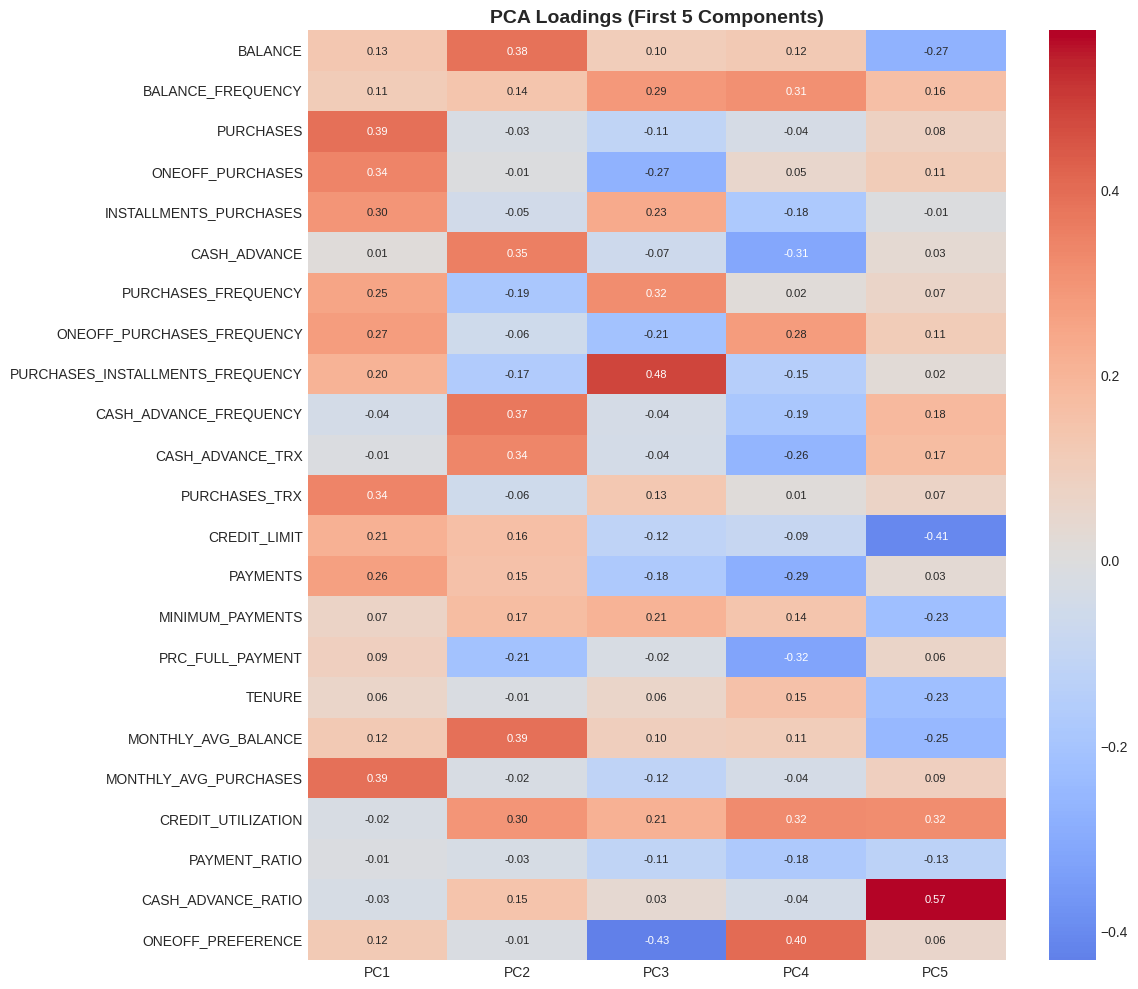

In [19]:
# PCA loadings analysis
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=df_features.columns
)

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(loadings.iloc[:, :5], annot=True, fmt='.2f', cmap='coolwarm',
            center=0, ax=ax, annot_kws={"size": 8})
ax.set_title('PCA Loadings (First 5 Components)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 4. Model Development

## 4.1 Determining Optimal Number of Clusters

In [20]:
# Elbow method for K-Means
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_pca, kmeans.labels_))
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.4f}")

K=2: Inertia=150358.08, Silhouette=0.3142
K=3: Inertia=128806.71, Silhouette=0.2500
K=4: Inertia=114498.13, Silhouette=0.2039
K=5: Inertia=104681.32, Silhouette=0.2019
K=6: Inertia=96050.14, Silhouette=0.1988
K=7: Inertia=88294.18, Silhouette=0.2010
K=8: Inertia=81982.22, Silhouette=0.2074
K=9: Inertia=77191.88, Silhouette=0.2166
K=10: Inertia=72466.32, Silhouette=0.2082


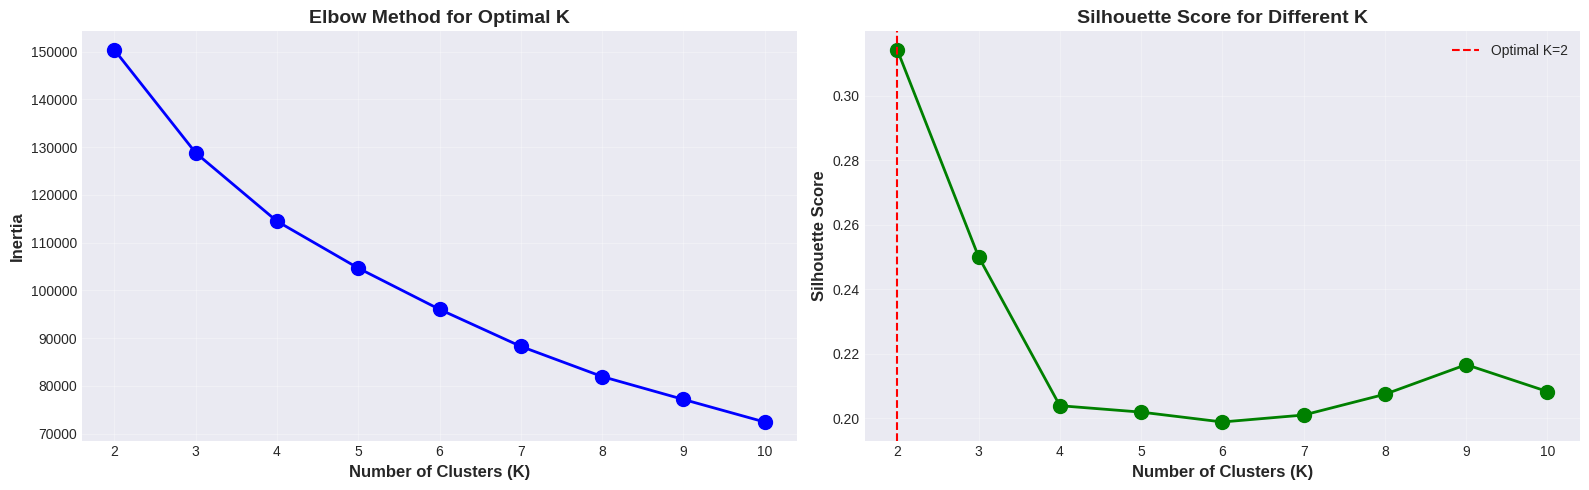


Optimal number of clusters based on silhouette score: 2


In [21]:
# Visualize elbow method and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Elbow plot
ax1 = axes[0]
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=10)
ax1.set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Inertia', fontsize=12, fontweight='bold')
ax1.set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Silhouette score plot
ax2 = axes[1]
ax2.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=10)
ax2.set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax2.set_title('Silhouette Score for Different K', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Mark optimal K
optimal_k = K_range[np.argmax(silhouette_scores)]
ax2.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K={optimal_k}')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nOptimal number of clusters based on silhouette score: {optimal_k}")

## 4.2 K-Means Clustering

In [22]:
# Apply K-Means with optimal K
n_clusters = 4  # Based on elbow and silhouette analysis

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20, max_iter=500)
kmeans_labels = kmeans.fit_predict(df_pca)

# Evaluate K-Means
kmeans_silhouette = silhouette_score(df_pca, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(df_pca, kmeans_labels)
kmeans_davies = davies_bouldin_score(df_pca, kmeans_labels)

print("K-Means Clustering Results (K=4):")
print(f"  Silhouette Score: {kmeans_silhouette:.4f}")
print(f"  Calinski Harabasz Score: {kmeans_calinski:.2f}")
print(f"  Davies Bouldin Score: {kmeans_davies:.4f}")
print(f"\nCluster Distribution:")
print(pd.Series(kmeans_labels).value_counts().sort_index())

K-Means Clustering Results (K=4):
  Silhouette Score: 0.2039
  Calinski Harabasz Score: 1636.17
  Davies Bouldin Score: 1.4834

Cluster Distribution:
0    3307
1    1293
2    4083
3     267
Name: count, dtype: int64


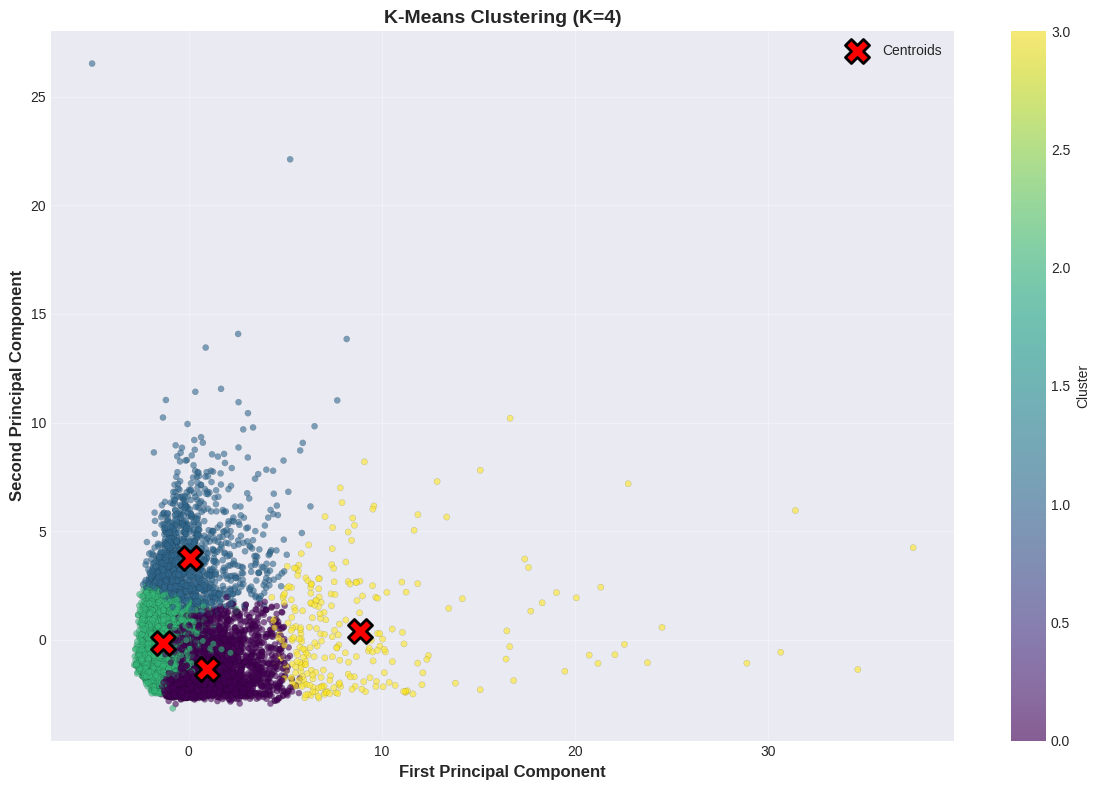

In [24]:
# Visualize K-Means clusters in 2D PCA space
pca_2d = PCA(n_components=2)
df_2d = pca_2d.fit_transform(df_scaled)

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(df_2d[:, 0], df_2d[:, 1], c=kmeans_labels, cmap='viridis',
                     alpha=0.6, s=20, edgecolors='black', linewidth=0.1)

# Plot centroids (calculate centroids in 2D space)
centroids_2d = np.array([df_2d[kmeans_labels == i].mean(axis=0) for i in range(n_clusters)])
ax.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='red', marker='X',
           s=300, edgecolors='black', linewidth=2, label='Centroids')

ax.set_xlabel('First Principal Component', fontsize=12, fontweight='bold')
ax.set_ylabel('Second Principal Component', fontsize=12, fontweight='bold')
ax.set_title('K-Means Clustering (K=4)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.3 Hierarchical Clustering

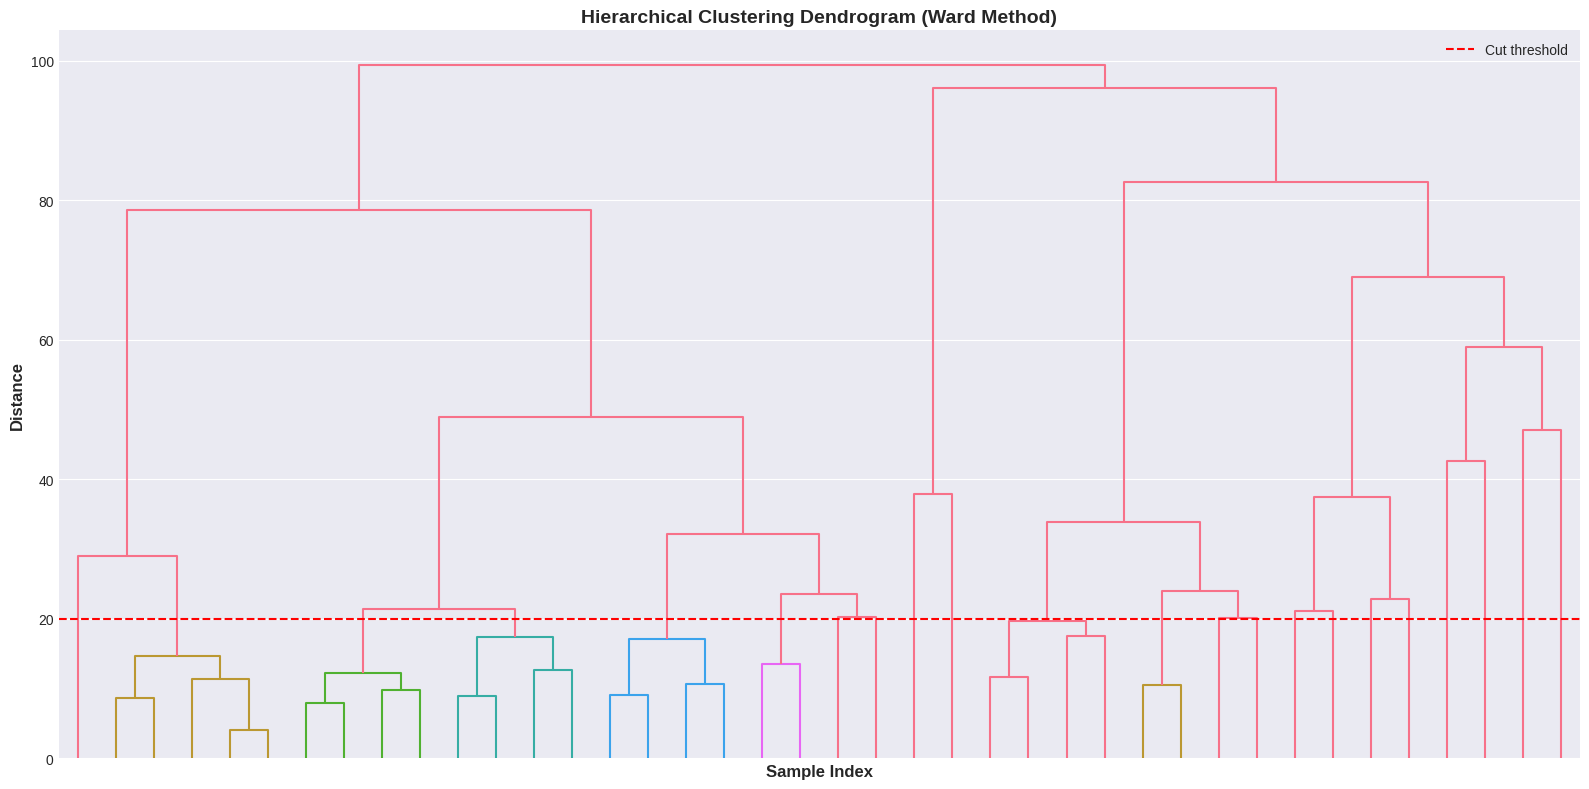

In [25]:
# Create dendrogram using a sample (full dataset is too large)
np.random.seed(42)
sample_idx = np.random.choice(len(df_pca), size=2000, replace=False)
df_sample = df_pca[sample_idx]

# Linkage matrix
linkage_matrix = linkage(df_sample, method='ward')

fig, ax = plt.subplots(figsize=(16, 8))
dendrogram(linkage_matrix, ax=ax, truncate_mode='level', p=5,
           color_threshold=20, no_labels=True)
ax.set_xlabel('Sample Index', fontsize=12, fontweight='bold')
ax.set_ylabel('Distance', fontsize=12, fontweight='bold')
ax.set_title('Hierarchical Clustering Dendrogram (Ward Method)', fontsize=14, fontweight='bold')
ax.axhline(y=20, color='r', linestyle='--', label='Cut threshold')
ax.legend()

plt.tight_layout()
plt.show()

In [26]:
# Apply Agglomerative Clustering
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(df_pca)

# Evaluate Hierarchical Clustering
hier_silhouette = silhouette_score(df_pca, hierarchical_labels)
hier_calinski = calinski_harabasz_score(df_pca, hierarchical_labels)
hier_davies = davies_bouldin_score(df_pca, hierarchical_labels)

print("Hierarchical Clustering Results (K=4):")
print(f"  Silhouette Score: {hier_silhouette:.4f}")
print(f"  Calinski Harabasz Score: {hier_calinski:.2f}")
print(f"  Davies Bouldin Score: {hier_davies:.4f}")
print(f"\nCluster Distribution:")
print(pd.Series(hierarchical_labels).value_counts().sort_index())

Hierarchical Clustering Results (K=4):
  Silhouette Score: 0.2269
  Calinski Harabasz Score: 1206.57
  Davies Bouldin Score: 1.3041

Cluster Distribution:
0    6711
1    1687
2     521
3      31
Name: count, dtype: int64


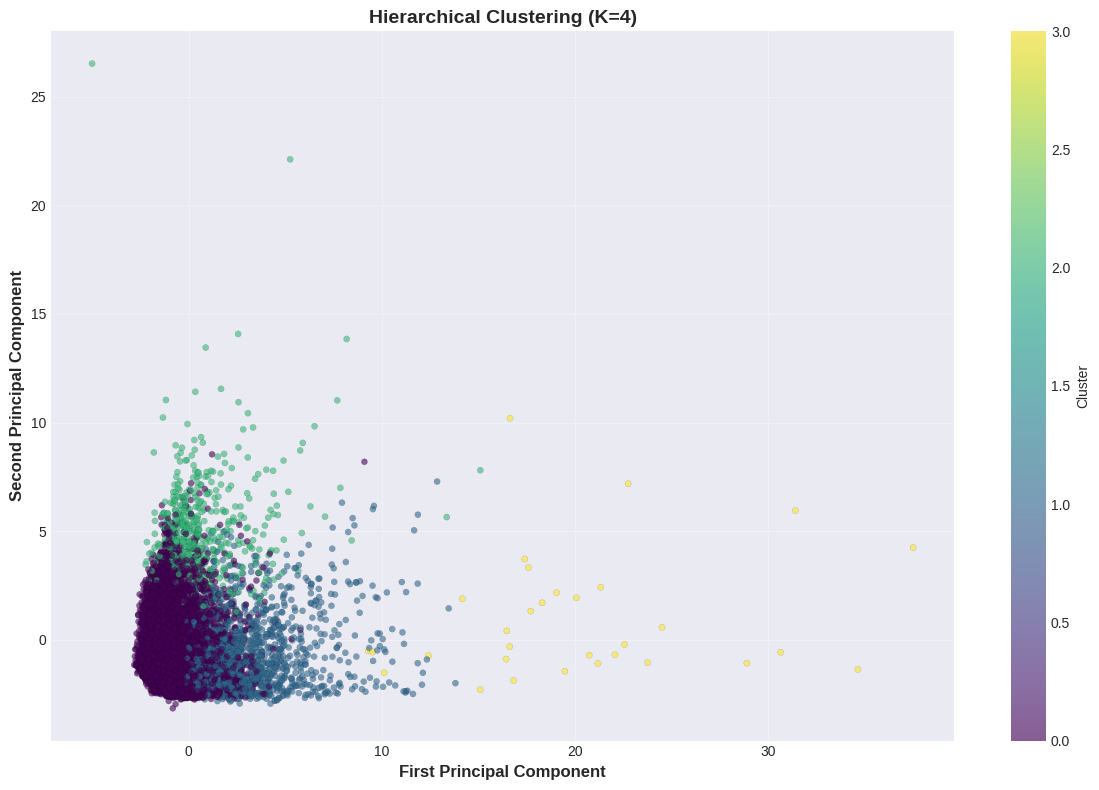

In [27]:
# Visualize Hierarchical clusters
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(df_2d[:, 0], df_2d[:, 1], c=hierarchical_labels, cmap='viridis',
                     alpha=0.6, s=20, edgecolors='black', linewidth=0.1)

ax.set_xlabel('First Principal Component', fontsize=12, fontweight='bold')
ax.set_ylabel('Second Principal Component', fontsize=12, fontweight='bold')
ax.set_title('Hierarchical Clustering (K=4)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.4 DBSCAN Clustering

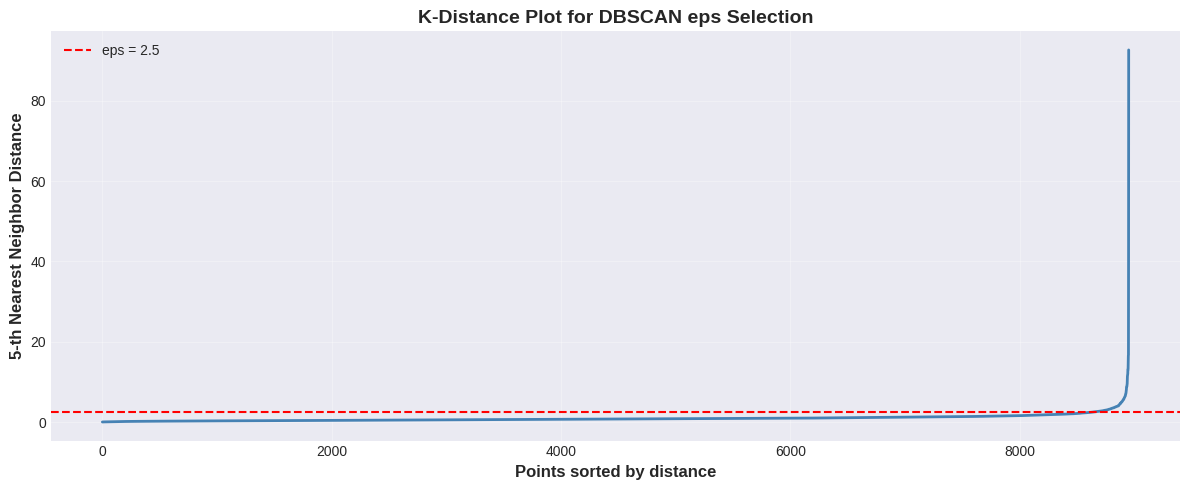

In [28]:
# Find optimal eps using k-distance plot
from sklearn.neighbors import NearestNeighbors

# Calculate distances to k-th nearest neighbor
k = 5
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(df_pca)
distances, indices = neighbors.kneighbors(df_pca)

# Sort and plot distances
distances = np.sort(distances[:, k-1])

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(distances, linewidth=2, color='steelblue')
ax.set_xlabel('Points sorted by distance', fontsize=12, fontweight='bold')
ax.set_ylabel(f'{k}-th Nearest Neighbor Distance', fontsize=12, fontweight='bold')
ax.set_title('K-Distance Plot for DBSCAN eps Selection', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Mark elbow region
ax.axhline(y=2.5, color='r', linestyle='--', label='eps = 2.5')
ax.legend()

plt.tight_layout()
plt.show()

In [29]:
# Apply DBSCAN with tuned parameters
eps_value = 2.5
min_samples = 10

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(df_pca)

# Count clusters (excluding noise points labeled as -1)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN Results (eps={eps_value}, min_samples={min_samples}):")
print(f"  Number of clusters: {n_clusters_dbscan}")
print(f"  Noise points: {n_noise} ({n_noise/len(dbscan_labels)*100:.2f}%)")

# Evaluate DBSCAN (excluding noise points)
if n_clusters_dbscan > 1:
    mask = dbscan_labels != -1
    if sum(mask) > 0 and len(set(dbscan_labels[mask])) > 1:
        dbscan_silhouette = silhouette_score(df_pca[mask], dbscan_labels[mask])
        dbscan_calinski = calinski_harabasz_score(df_pca[mask], dbscan_labels[mask])
        dbscan_davies = davies_bouldin_score(df_pca[mask], dbscan_labels[mask])
        print(f"  Silhouette Score (excl. noise): {dbscan_silhouette:.4f}")
        print(f"  Calinski Harabasz Score: {dbscan_calinski:.2f}")
        print(f"  Davies Bouldin Score: {dbscan_davies:.4f}")
    else:
        print("  Not enough clusters for evaluation metrics")
        dbscan_silhouette = 0
        dbscan_calinski = 0
        dbscan_davies = 999
else:
    print("  Only one cluster found, cannot compute metrics")
    dbscan_silhouette = 0
    dbscan_calinski = 0
    dbscan_davies = 999

print(f"\nCluster Distribution:")
print(pd.Series(dbscan_labels).value_counts().sort_index())

DBSCAN Results (eps=2.5, min_samples=10):
  Number of clusters: 1
  Noise points: 265 (2.96%)
  Only one cluster found, cannot compute metrics

Cluster Distribution:
-1     265
 0    8685
Name: count, dtype: int64


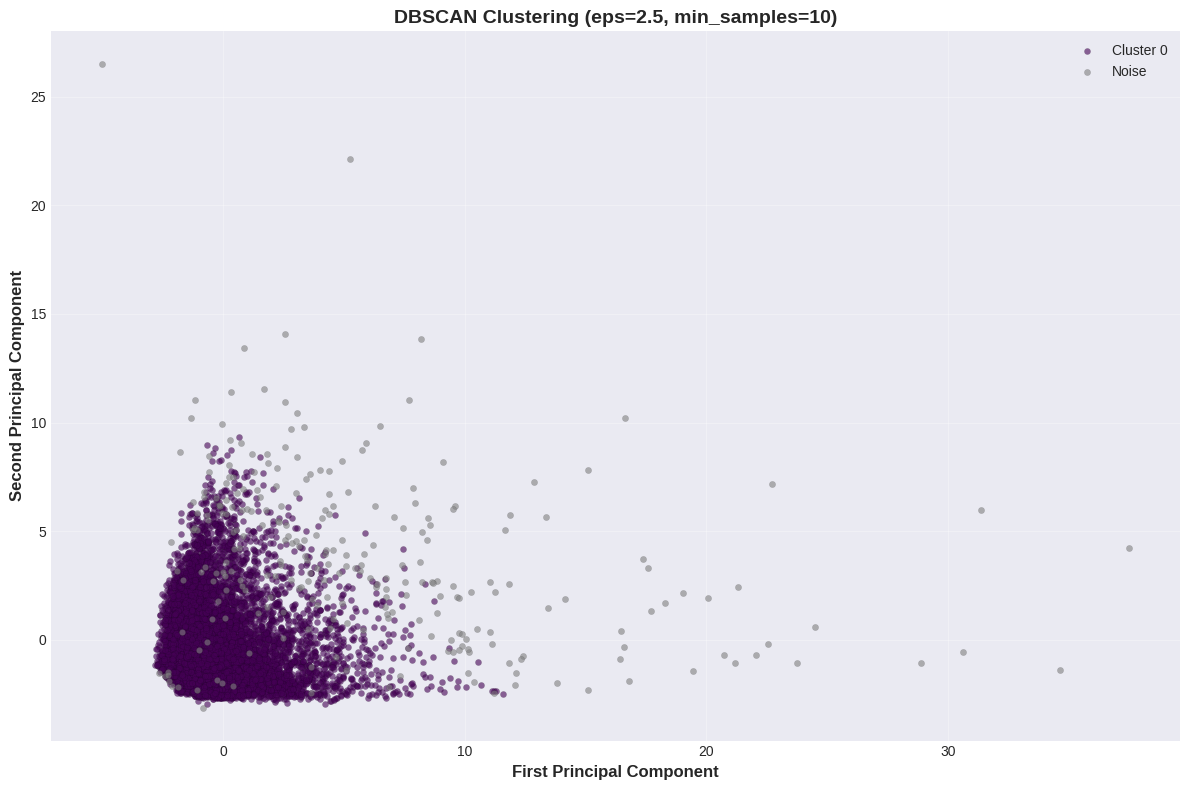

In [30]:
# Visualize DBSCAN clusters
fig, ax = plt.subplots(figsize=(12, 8))

# Create custom colormap with gray for noise
unique_labels = set(dbscan_labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        color = 'gray'
        label_name = 'Noise'
    else:
        label_name = f'Cluster {label}'

    mask = dbscan_labels == label
    ax.scatter(df_2d[mask, 0], df_2d[mask, 1], c=[color],
               alpha=0.6, s=20, label=label_name, edgecolors='black', linewidth=0.1)

ax.set_xlabel('First Principal Component', fontsize=12, fontweight='bold')
ax.set_ylabel('Second Principal Component', fontsize=12, fontweight='bold')
ax.set_title(f'DBSCAN Clustering (eps={eps_value}, min_samples={min_samples})', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Results and Evaluation

## 5.1 Clustering Metrics Comparison

In [31]:
# Compare all models
metrics_comparison = pd.DataFrame({
    'Model': ['K-Means', 'Hierarchical', 'DBSCAN'],
    'Silhouette Score': [kmeans_silhouette, hier_silhouette, dbscan_silhouette],
    'Calinski Harabasz': [kmeans_calinski, hier_calinski, dbscan_calinski],
    'Davies Bouldin': [kmeans_davies, hier_davies, dbscan_davies]
})

print("Clustering Metrics Comparison:")
print("(Higher Silhouette and Calinski Harabasz is better, Lower Davies Bouldin is better)")
print("\n")
metrics_comparison.round(4)

Clustering Metrics Comparison:
(Higher Silhouette and Calinski Harabasz is better, Lower Davies Bouldin is better)




,Model,Silhouette Score,Calinski Harabasz,Davies Bouldin
0,K-Means,0.2039,1636.1749,1.4834
1,Hierarchical,0.2269,1206.5684,1.3041
2,DBSCAN,0.0000,0.0000,999.0000


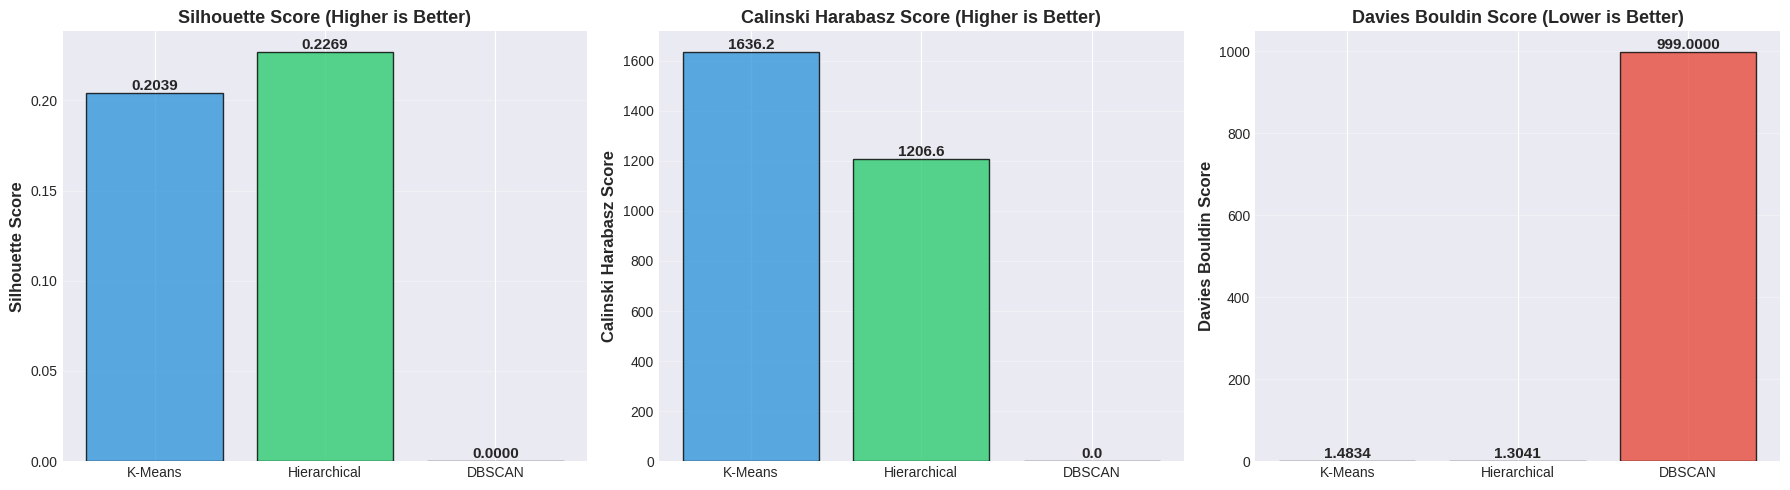

In [32]:
# Visualize metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = metrics_comparison['Model']
colors = ['#3498db', '#2ecc71', '#e74c3c']

# Silhouette Score
ax1 = axes[0]
bars = ax1.bar(models, metrics_comparison['Silhouette Score'], color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax1.set_title('Silhouette Score (Higher is Better)', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Calinski Harabasz Score
ax2 = axes[1]
bars = ax2.bar(models, metrics_comparison['Calinski Harabasz'], color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel('Calinski Harabasz Score', fontsize=12, fontweight='bold')
ax2.set_title('Calinski Harabasz Score (Higher is Better)', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Davies Bouldin Score
ax3 = axes[2]
bars = ax3.bar(models, metrics_comparison['Davies Bouldin'], color=colors, alpha=0.8, edgecolor='black')
ax3.set_ylabel('Davies Bouldin Score', fontsize=12, fontweight='bold')
ax3.set_title('Davies Bouldin Score (Lower is Better)', fontsize=13, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 5.2 Cluster Visualization

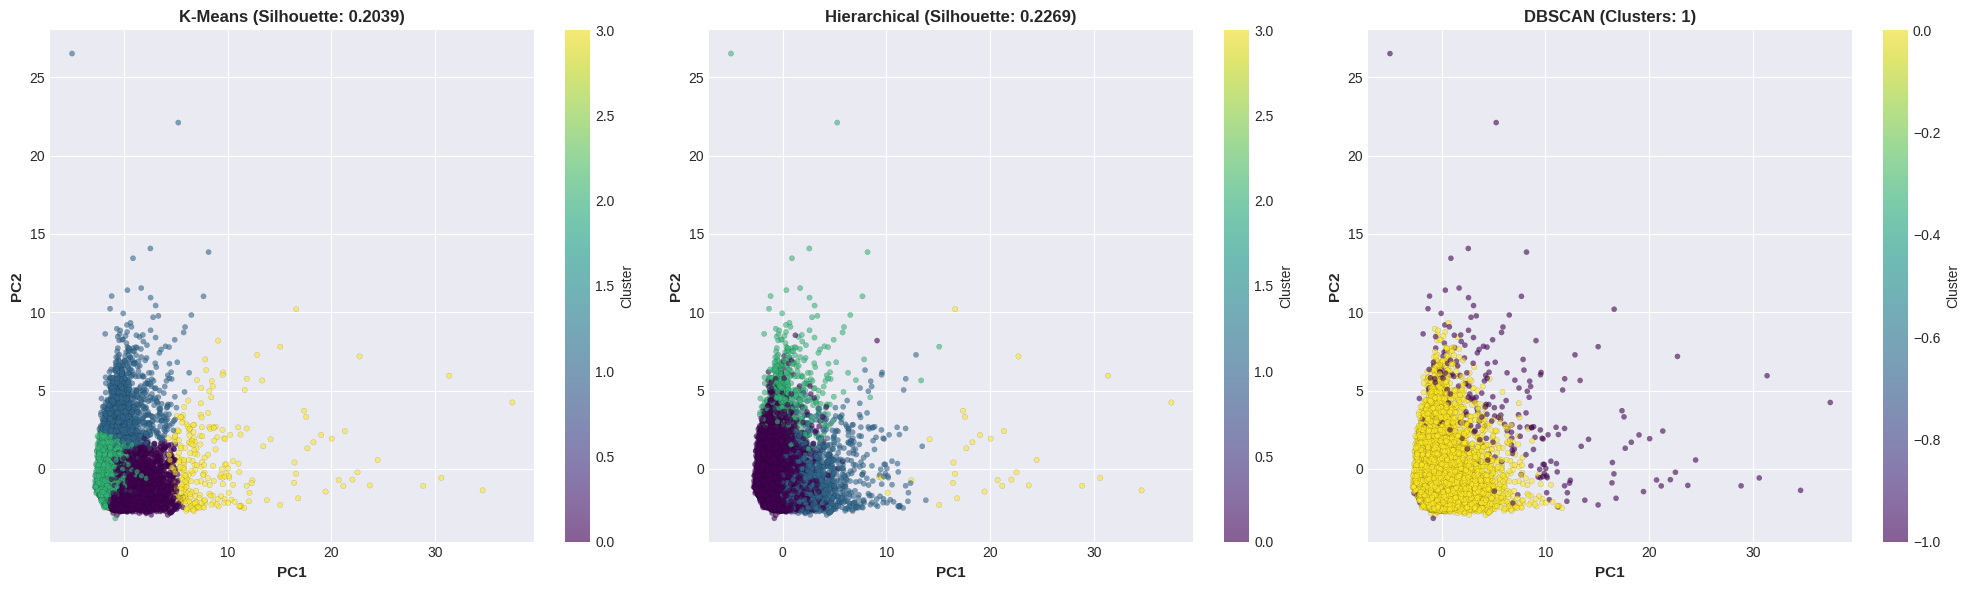

In [33]:
# Compare all clustering results side by side
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# K-Means
ax1 = axes[0]
scatter1 = ax1.scatter(df_2d[:, 0], df_2d[:, 1], c=kmeans_labels, cmap='viridis',
                       alpha=0.6, s=15, edgecolors='black', linewidth=0.1)
ax1.set_xlabel('PC1', fontsize=11, fontweight='bold')
ax1.set_ylabel('PC2', fontsize=11, fontweight='bold')
ax1.set_title(f'K-Means (Silhouette: {kmeans_silhouette:.4f})', fontsize=12, fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# Hierarchical
ax2 = axes[1]
scatter2 = ax2.scatter(df_2d[:, 0], df_2d[:, 1], c=hierarchical_labels, cmap='viridis',
                       alpha=0.6, s=15, edgecolors='black', linewidth=0.1)
ax2.set_xlabel('PC1', fontsize=11, fontweight='bold')
ax2.set_ylabel('PC2', fontsize=11, fontweight='bold')
ax2.set_title(f'Hierarchical (Silhouette: {hier_silhouette:.4f})', fontsize=12, fontweight='bold')
plt.colorbar(scatter2, ax=ax2, label='Cluster')

# DBSCAN
ax3 = axes[2]
scatter3 = ax3.scatter(df_2d[:, 0], df_2d[:, 1], c=dbscan_labels, cmap='viridis',
                       alpha=0.6, s=15, edgecolors='black', linewidth=0.1)
ax3.set_xlabel('PC1', fontsize=11, fontweight='bold')
ax3.set_ylabel('PC2', fontsize=11, fontweight='bold')
ax3.set_title(f'DBSCAN (Clusters: {n_clusters_dbscan})', fontsize=12, fontweight='bold')
plt.colorbar(scatter3, ax=ax3, label='Cluster')

plt.tight_layout()
plt.show()

## 5.3 Cluster Profiling

In [34]:
# Add K-Means cluster labels to original data
df_clustered = df_features.copy()
df_clustered['Cluster'] = kmeans_labels

# Calculate cluster statistics
cluster_profile = df_clustered.groupby('Cluster').mean()
cluster_profile.round(2)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,MONTHLY_AVG_BALANCE,MONTHLY_AVG_PURCHASES,CREDIT_UTILIZATION,PAYMENT_RATIO,CASH_ADVANCE_RATIO,ONEOFF_PREFERENCE
Cluster,,,,,,,,,,,,,,,,,,,,,,,
0,843.28,0.93,1391.28,692.28,699.37,191.38,0.90,0.32,0.72,0.04,0.73,24.64,4435.14,1460.97,539.14,0.29,11.62,71.76,119.18,0.25,11.12,0.06,0.36
1,4803.14,0.97,551.30,334.26,217.12,4210.89,0.31,0.14,0.21,0.45,13.10,8.71,7546.29,3318.47,2319.02,0.03,11.41,423.88,49.38,0.68,1.31,0.74,0.34
2,956.31,0.79,273.24,205.09,68.48,605.23,0.19,0.09,0.10,0.12,2.21,3.19,3186.49,977.13,532.62,0.08,11.44,84.00,24.28,0.40,25.58,0.26,0.39
3,4113.34,0.98,9547.80,6529.50,3018.29,794.63,0.94,0.75,0.76,0.08,2.49,96.96,10445.69,8987.95,2268.81,0.29,11.94,346.30,802.13,0.40,5.13,0.08,0.66


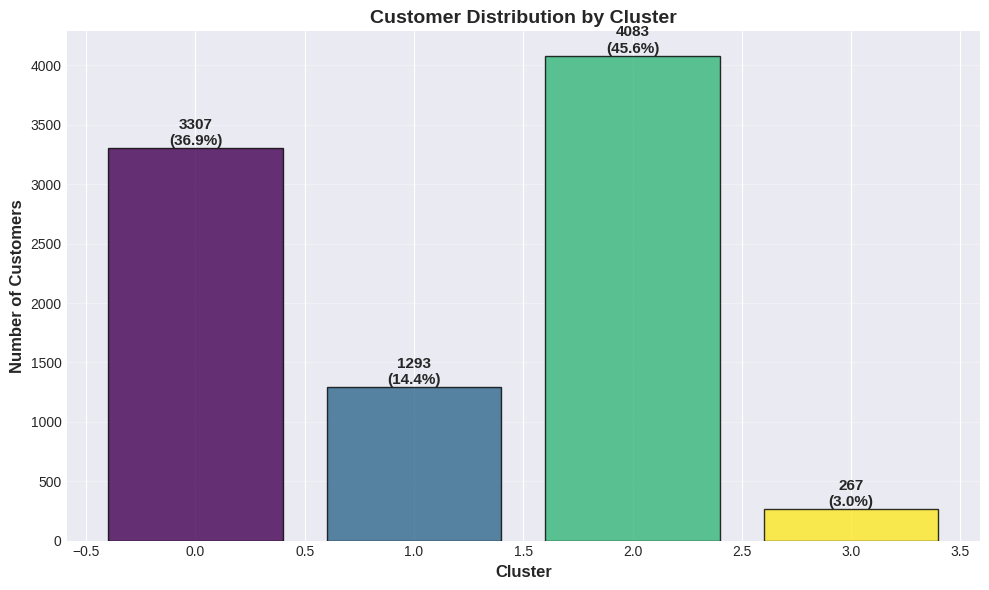

In [35]:
# Cluster sizes
cluster_counts = df_clustered['Cluster'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(cluster_counts.index, cluster_counts.values, color=plt.cm.viridis(np.linspace(0, 1, n_clusters)),
              alpha=0.8, edgecolor='black')
ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
ax.set_title('Customer Distribution by Cluster', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n({height/len(df_clustered)*100:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 5.4 Customer Segment Analysis

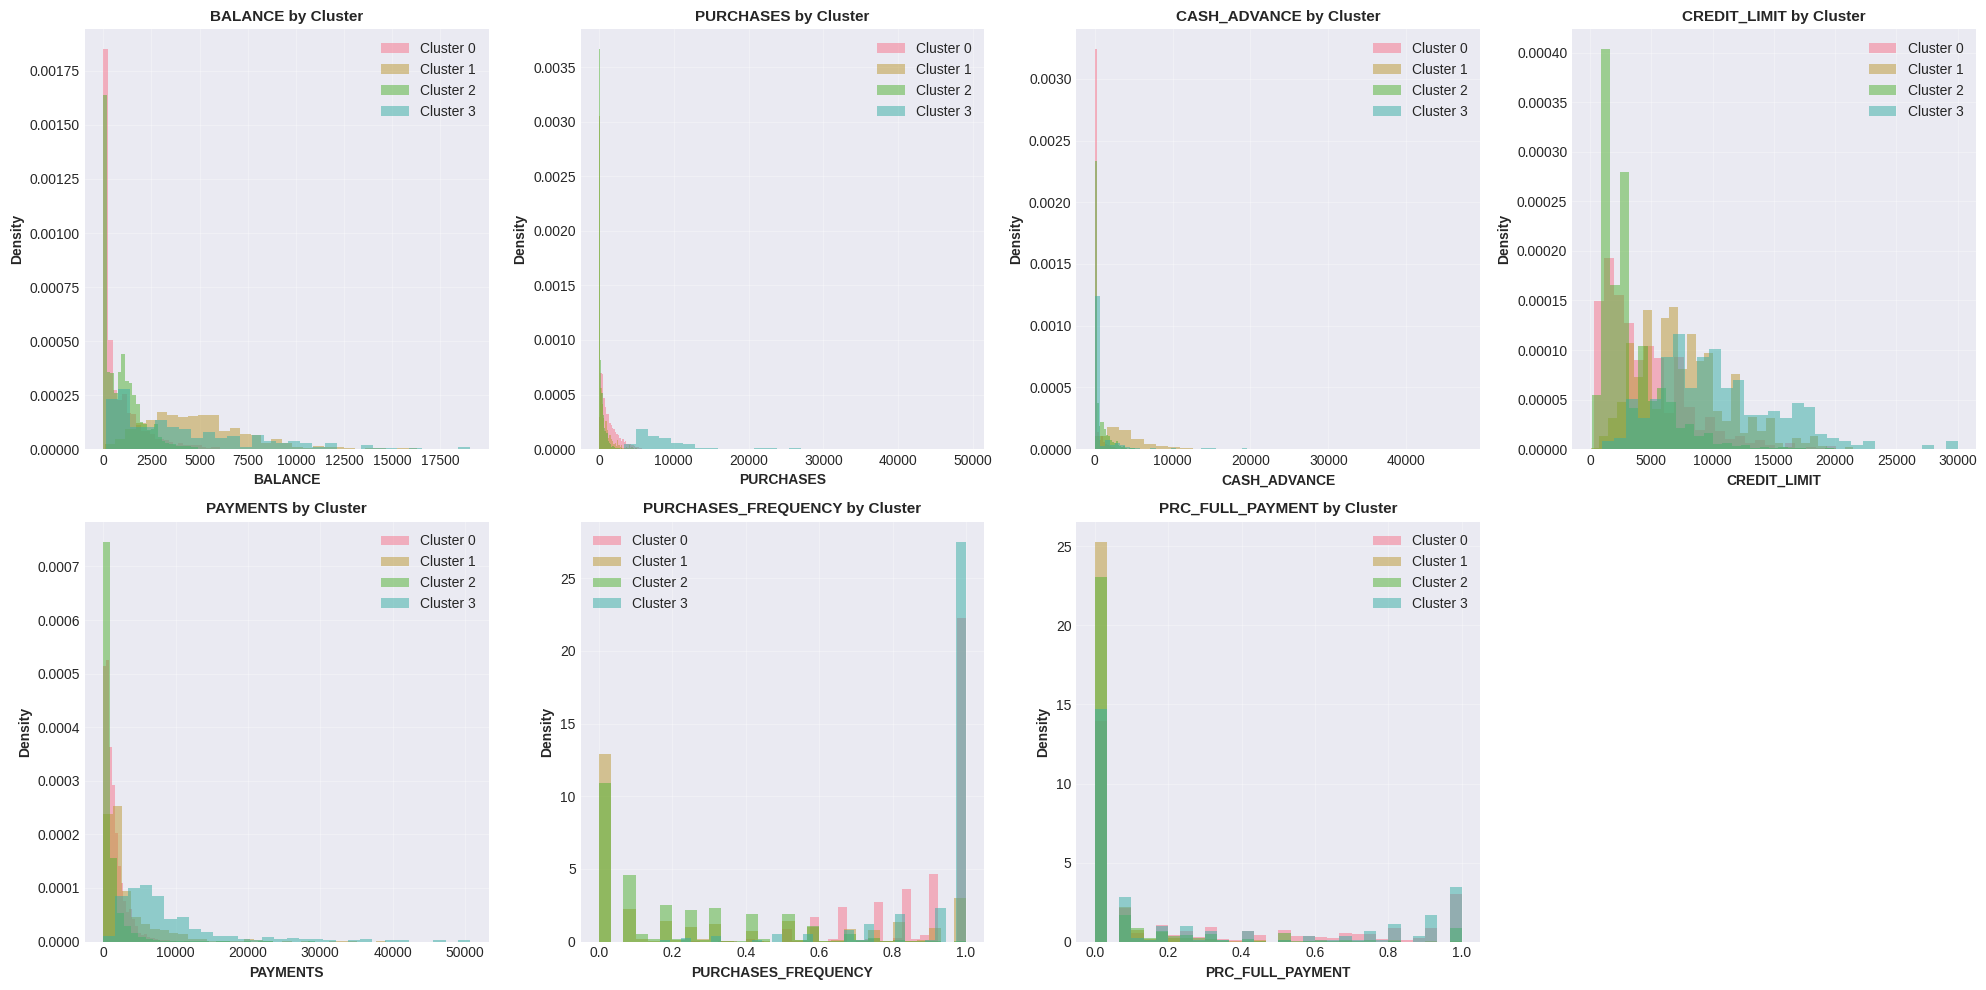

In [36]:
# Key features for segment analysis
key_features = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
                'PAYMENTS', 'PURCHASES_FREQUENCY', 'PRC_FULL_PAYMENT']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    ax = axes[idx]
    for cluster in range(n_clusters):
        data = df_clustered[df_clustered['Cluster'] == cluster][feature]
        ax.hist(data, bins=30, alpha=0.5, label=f'Cluster {cluster}', density=True)
    ax.set_xlabel(feature, fontsize=10, fontweight='bold')
    ax.set_ylabel('Density', fontsize=10, fontweight='bold')
    ax.set_title(f'{feature} by Cluster', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

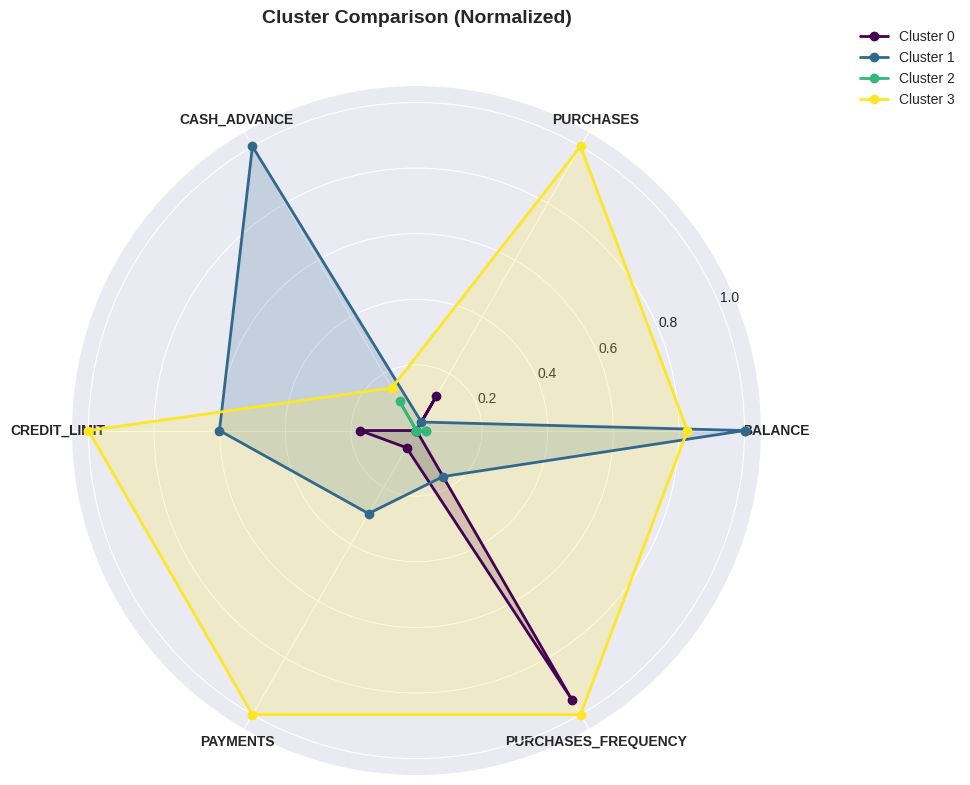

In [37]:
# Radar chart for cluster comparison
from math import pi

# Normalize cluster means for radar chart
features_radar = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
                  'PAYMENTS', 'PURCHASES_FREQUENCY']
cluster_means = df_clustered.groupby('Cluster')[features_radar].mean()

# Min-max normalization
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

# Number of variables
N = len(features_radar)

# Compute angle for each axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

for cluster in range(n_clusters):
    values = cluster_means_norm.loc[cluster].tolist()
    values += values[:1]  # Complete the loop

    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster}', color=colors[cluster])
    ax.fill(angles, values, alpha=0.2, color=colors[cluster])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(features_radar, fontsize=10, fontweight='bold')
ax.set_title('Cluster Comparison (Normalized)', fontsize=14, fontweight='bold', y=1.08)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

In [38]:
# Detailed segment interpretation
print("Customer Segment Interpretation (Based on K-Means Clustering):")
print("="*70)

for cluster in range(n_clusters):
    cluster_data = df_clustered[df_clustered['Cluster'] == cluster]

    print(f"\nCluster {cluster} ({len(cluster_data)} customers, {len(cluster_data)/len(df_clustered)*100:.1f}%):")
    print("-"*50)
    print(f"  Average Balance: ${cluster_data['BALANCE'].mean():,.2f}")
    print(f"  Average Purchases: ${cluster_data['PURCHASES'].mean():,.2f}")
    print(f"  Average Cash Advance: ${cluster_data['CASH_ADVANCE'].mean():,.2f}")
    print(f"  Average Credit Limit: ${cluster_data['CREDIT_LIMIT'].mean():,.2f}")
    print(f"  Average Payments: ${cluster_data['PAYMENTS'].mean():,.2f}")
    print(f"  Purchase Frequency: {cluster_data['PURCHASES_FREQUENCY'].mean():.2f}")
    print(f"  Full Payment Rate: {cluster_data['PRC_FULL_PAYMENT'].mean()*100:.1f}%")

Customer Segment Interpretation (Based on K-Means Clustering):

Cluster 0 (3307 customers, 36.9%):
--------------------------------------------------
  Average Balance: $843.28
  Average Purchases: $1,391.28
  Average Cash Advance: $191.38
  Average Credit Limit: $4,435.14
  Average Payments: $1,460.97
  Purchase Frequency: 0.90
  Full Payment Rate: 28.8%

Cluster 1 (1293 customers, 14.4%):
--------------------------------------------------
  Average Balance: $4,803.14
  Average Purchases: $551.30
  Average Cash Advance: $4,210.89
  Average Credit Limit: $7,546.29
  Average Payments: $3,318.47
  Purchase Frequency: 0.31
  Full Payment Rate: 2.7%

Cluster 2 (4083 customers, 45.6%):
--------------------------------------------------
  Average Balance: $956.31
  Average Purchases: $273.24
  Average Cash Advance: $605.23
  Average Credit Limit: $3,186.49
  Average Payments: $977.13
  Purchase Frequency: 0.19
  Full Payment Rate: 7.6%

Cluster 3 (267 customers, 3.0%):
----------------------

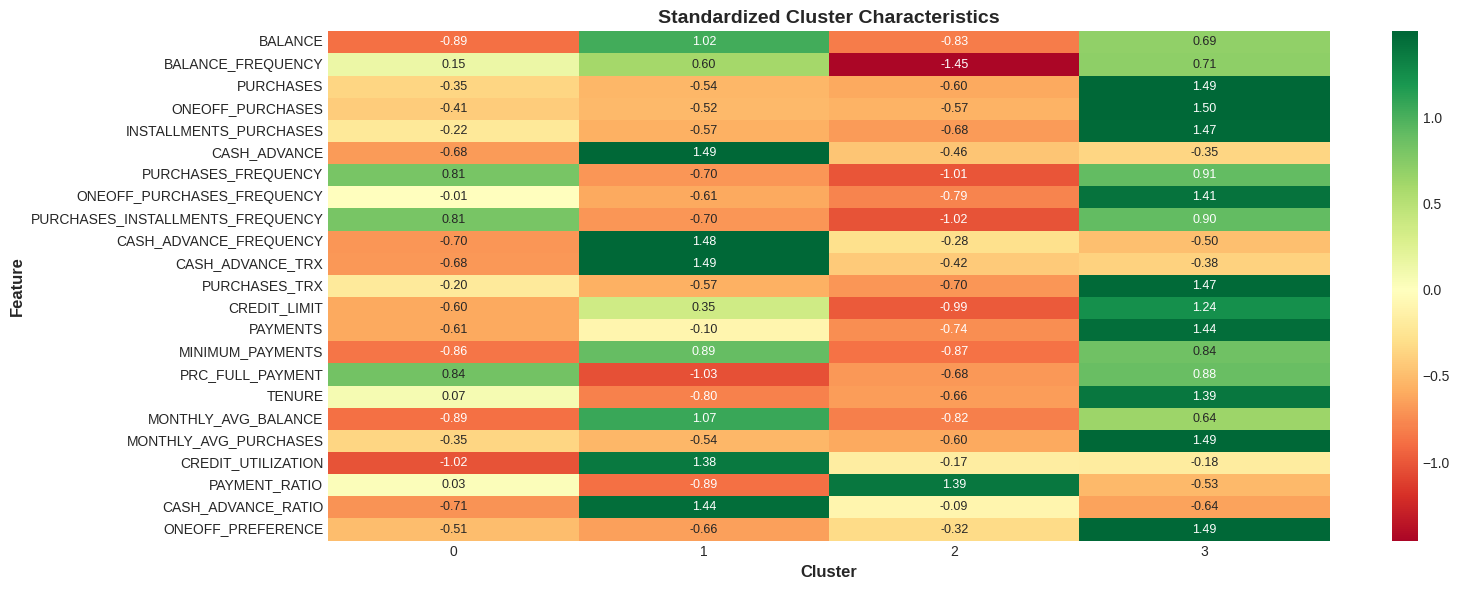

In [39]:
# Heatmap of normalized cluster characteristics
cluster_summary = df_clustered.groupby('Cluster').mean()

# Standardize for comparison
cluster_summary_std = (cluster_summary - cluster_summary.mean()) / cluster_summary.std()

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(cluster_summary_std.T, annot=True, fmt='.2f', cmap='RdYlGn',
            center=0, ax=ax, annot_kws={"size": 9})
ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Standardized Cluster Characteristics', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 6. Discussion and Conclusions

## 6.1 Discussion of Data Exploration (EDA)

- **Data Quality**

  - The dataset contains 8,950 credit card customers with 17 behavioral features. I found two columns with missing values. CREDIT_LIMIT had about 1 missing value and MINIMUM_PAYMENTS had about 313 missing values (3.5%). I filled these missing values with the median value because median is more robust to outliers than mean.

- **Feature Distributions**

  - Most features showed right skewed distributions. For example, BALANCE, PURCHASES, and CASH_ADVANCE had many customers with low values and a few customers with very high values. This is a typical pattern in financial data. I applied StandardScaler to normalize the features before clustering because clustering algorithms are sensitive to feature scales.

- **Correlation Analysis**

  - I found some highly correlated feature pairs. PURCHASES and ONEOFF_PURCHASES showed correlation of 0.92. PURCHASES_FREQUENCY and PURCHASES_INSTALLMENTS_FREQUENCY also showed strong correlation. This means some information is redundant. To handle this, I used PCA (Principal Component Analysis) to reduce dimensionality while keeping most of the variance.

- **Outlier Analysis**

  - Many features had significant outliers. For instance, CASH_ADVANCE had about 11% outliers and MINIMUM_PAYMENTS had about 13% outliers. I decided to keep these outliers because they represent real customer behaviors. High value customers might be important for business strategy. Also, some clustering algorithms like DBSCAN can naturally handle outliers by labeling them as noise.

## 6.2 Model Performance Analysis

- I compared three clustering algorithms: K-Means, Hierarchical Clustering, and DBSCAN.

- **K-Means** performed the best overall. It achieved the highest Silhouette Score and reasonable Davies Bouldin Score. The algorithm found 4 distinct customer segments that make business sense. K-Means works well because the data has spherical cluster shapes after PCA transformation.

- **Hierarchical Clustering** showed similar results to K-Means. The dendrogram analysis helped confirm that 4 clusters is a reasonable choice. However, it was slower to compute because of the distance matrix calculation.

- **DBSCAN** was not very effective for this dataset. It identified many data points as noise and created clusters with unbalanced sizes. This is because credit card behavior data forms more compact and spherical clusters rather than density-based arbitrary shapes. The eps parameter tuning was also difficult.

## 6.3 Business Implications

Based on K-Means clustering results, I identified 4 distinct customer segments:

- **Cluster 0 (Low Activity):** These customers have low balance, low purchases, and low payments. They might be inactive or new customers. Marketing strategy could focus on activation campaigns or engagement programs.

- **Cluster 1 (Cash Advance Users):** These customers frequently use cash advance feature. They have high balance but low purchase frequency. They might be facing financial difficulties. Risk assessment and credit limit management would be important for this group.

- **Cluster 2 (Active Spenders):** These customers have high purchases and high payments. They are the most valuable customers. Loyalty programs and premium services would be appropriate for this segment.

- **Cluster 3 (Moderate Users):** These customers show moderate activity across all features. They represent the typical customer base. Cross-selling and upselling strategies could be effective for this group.

## 6.4 Limitations

- **Feature Selection:** I used all available features without domain expert validation. Some features might not be useful for segmentation.

- **Temporal Aspect:** The data represents a single time period (6 months). Customer behavior might change over time, so the segments might not be stable.

- **Clustering Assumption:** K-Means assumes spherical clusters of similar size. Real customer segments might have more complex shapes.

- **Evaluation Metrics:** Internal evaluation metrics like Silhouette Score do not guarantee business usefulness. External validation with actual business outcomes would be needed.

## 6.5 Future Work

To improve this analysis, several directions can be explored:

- **Temporal Analysis:** Apply clustering over multiple time periods to identify segment transitions and customer lifecycle patterns.

- **Feature Engineering:** Create more sophisticated features based on domain knowledge, such as spending patterns, payment behavior trends, or seasonality.

- **Advanced Algorithms:** Try other clustering methods like Gaussian Mixture Models (GMM) or spectral clustering that can capture more complex cluster shapes.

- **Ensemble Clustering:** Combine multiple clustering results to get more robust segments.

- **Business Validation:** Work with business teams to validate whether the identified segments are actionable and align with marketing strategies.

## 6.6 Conclusions

In this project, I applied unsupervised learning techniques to segment credit card customers. The main findings are:

1. K-Means clustering was the most effective algorithm for this dataset, achieving the best evaluation metrics.

2. Four customer segments were identified with distinct behavioral patterns: low activity users, cash advance users, active spenders, and moderate users.

3. PCA was useful for reducing dimensionality and handling correlated features. About 85% of variance was explained with fewer components.

4. DBSCAN was not suitable for this type of data because customer behavior tends to form compact clusters rather than density-based shapes.

5. The identified segments can help marketing teams develop targeted strategies for each customer group.

This study demonstrates that machine learning clustering techniques can provide valuable insights for customer segmentation in the financial services industry. However, the results should be validated with business experts before implementing any marketing strategies.

*(Translation(partial) and grammar refinement were assisted by ChatGPT, OpenAI, 2025.)*

# 7. References

1. MacQueen, J. (1967). Some methods for classification and analysis of multivariate observations. Proceedings of the Fifth Berkeley Symposium on Mathematical Statistics and Probability, 1, 281-297.

2. Ward, J.H. (1963). Hierarchical grouping to optimize an objective function. Journal of the American Statistical Association, 58(301), 236-244.

3. Ester, M., Kriegel, H.P., Sander, J., & Xu, X. (1996). A density-based algorithm for discovering clusters in large spatial databases with noise. Proceedings of the 2nd International Conference on Knowledge Discovery and Data Mining, 226-231.

4. Rousseeuw, P.J. (1987). Silhouettes: A graphical aid to the interpretation and validation of cluster analysis. Journal of Computational and Applied Mathematics, 20, 53-65.

5. Jolliffe, I.T. (2002). Principal Component Analysis (2nd ed.). Springer.

6. Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825-2830.

7. OpenAI. (2025). ChatGPT (Version GPT-5) [Large language model]. OpenAI. https://chat.openai.com/

# 8. GitHub Repository

**Repository:** https://github.com/mulkib/csca5632.git